# Figures that combine time feature (daily, weekly, weekend, monthly, quarterly, yearly) with 5 combinations

- Energy & EV
- Energy & Solar Panel
- Energy & Heat Pump

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools


# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


In [2]:
# Path to the pickle file
file_path = os.path.join("P6269_1_50_DMK_Sample_Elek", "data_clean", "clean_electricity_data.pkl")

# Load the pickle file into df
df = pd.read_pickle(file_path)

# Verify the data loaded correctly
print(f"DataFrame loaded with {len(df)} rows and {len(df.columns)} columns")
df.info()

DataFrame loaded with 200000 rows and 19 columns
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 19 columns):
 #   Column                      Non-Null Count   Dtype              
---  ------                      --------------   -----              
 0   EAN_ID                      200000 non-null  int64              
 1   Date                        200000 non-null  datetime64[ns]     
 2   Date_StartHour              200000 non-null  datetime64[ns, UTC]
 3   Volume_Consumption_kWh      200000 non-null  float64            
 4   Volume_Injection_kWh        200000 non-null  float64            
 5   Heat_Pump_Indicator         200000 non-null  int64              
 6   Electric_Vehicle_Indicator  200000 non-null  int64              
 7   PV_Installation_Indicator   200000 non-null  int64              
 8   Contract_Category           200000 non-null  object             
 9   Hour                        200000 non-null  int32              


In [3]:
df

,EAN_ID,Date,Date_StartHour,Volume_Consumption_kWh,Volume_Injection_kWh,Heat_Pump_Indicator,Electric_Vehicle_Indicator,PV_Installation_Indicator,Contract_Category,Hour,Minute,Day,Month,Year,Day_of_Week_Name,Weekday_Weekend,Week,Quarter,Day_Name
0,1,2022-01-01,2022-01-01 00:00:00+00:00,0.760,0.000,0,1,0,Residentieel,0,0,1,1,2022,Saturday,Weekend,52,1,Saturday
1,1,2022-01-01,2022-01-01 00:15:00+00:00,0.789,0.000,0,1,0,Residentieel,0,15,1,1,2022,Saturday,Weekend,52,1,Saturday
2,1,2022-01-01,2022-01-01 00:30:00+00:00,1.131,0.000,0,1,0,Residentieel,0,30,1,1,2022,Saturday,Weekend,52,1,Saturday
3,1,2022-01-01,2022-01-01 00:45:00+00:00,0.791,0.000,0,1,0,Residentieel,0,45,1,1,2022,Saturday,Weekend,52,1,Saturday
4,1,2022-01-01,2022-01-01 01:00:00+00:00,0.791,0.000,0,1,0,Residentieel,1,0,1,1,2022,Saturday,Weekend,52,1,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,6,2022-09-16,2022-09-16 06:45:00+00:00,0.258,0.001,0,0,1,Residentieel,6,45,16,9,2022,Friday,Weekday,37,3,Friday
199996,6,2022-09-16,2022-09-16 07:00:00+00:00,0.000,0.050,0,0,1,Residentieel,7,0,16,9,2022,Friday,Weekday,37,3,Friday
199997,6,2022-09-16,2022-09-16 07:15:00+00:00,0.000,0.027,0,0,1,Residentieel,7,15,16,9,2022,Friday,Weekday,37,3,Friday
199998,6,2022-09-16,2022-09-16 07:30:00+00:00,0.000,0.084,0,0,1,Residentieel,7,30,16,9,2022,Friday,Weekday,37,3,Friday


# 2. Time Serie (weekday vs weekend) vs 5 combinations

In [18]:
def analyze_weekday_weekend_by_indicator(df, indicator_column, aggregation_method='sum'):
    """
    Analyze weekday vs weekend consumption patterns by a binary indicator (0/1).
    
    Parameters:
    - df: DataFrame containing the data
    - indicator_column: Name of the column with binary indicator (e.g., 'Electric_Vehicle_Indicator')
    - aggregation_method: Method to aggregate energy values ('sum' or 'mean')
    """
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    
    if indicator_column not in df.columns:
        print(f"{indicator_column} not found in the dataset")
        return
    
    # Map indicator names to feature names and colors
    indicator_mapping = {
        'Electric_Vehicle_Indicator': {'name': 'Electric Vehicle', 
                                      'consumption_colors': ['skyblue', 'navy'],
                                      'injection_colors': ['lightgreen', 'darkgreen']},
        'Heat_Pump_Indicator': {'name': 'Heat Pump', 
                               'consumption_colors': ['lightgreen', 'darkgreen'],
                               'injection_colors': ['lightcoral', 'darkred']},
        'PV_Installation_Indicator': {'name': 'Solar Panel', 
                                     'consumption_colors': ['gold', 'darkorange'],
                                     'injection_colors': ['plum', 'purple']}
    }
    
    # Get feature info or create default
    feature_info = indicator_mapping.get(indicator_column, {
        'name': indicator_column.replace('_Indicator', '').replace('_', ' '),
        'consumption_colors': ['lightblue', 'darkblue'],
        'injection_colors': ['lightgreen', 'darkgreen']
    })
    
    feature_name = feature_info['name']
    consumption_colors = feature_info['consumption_colors']
    injection_colors = feature_info['injection_colors']
        
    # Validate aggregation method
    if aggregation_method not in ['sum', 'mean']:
        print(f"Invalid aggregation method: {aggregation_method}. Using 'sum' instead.")
        aggregation_method = 'sum'
    
    # Group by both Weekday_Weekend and the indicator
    combined_agg = df.groupby(['Weekday_Weekend', indicator_column]).agg({
        'Volume_Consumption_kWh': aggregation_method,
        'Volume_Injection_kWh': aggregation_method,
        'EAN_ID': 'nunique'  # Count unique households
    }).reset_index()
    
    # Create a mapping dictionary based on available values
    index_mapping = {}
    if 0 in combined_agg[indicator_column].unique():
        index_mapping[0] = f'No {feature_name}'
    if 1 in combined_agg[indicator_column].unique():
        index_mapping[1] = f'Has {feature_name}'
    
    # Apply mapping to create a new readable column
    combined_agg['Status'] = combined_agg[indicator_column].map(
        lambda x: index_mapping.get(x, f'Value {x}')
    )
    
    agg_display_name = "Total" if aggregation_method == 'sum' else "Average"
    print(f"{agg_display_name} Weekend vs Weekday Energy by {feature_name} Ownership:")
    display(combined_agg)
    
    # Prepare for visualization
    plt.figure(figsize=(14, 8))
    
    # Get unique categories
    categories = combined_agg['Weekday_Weekend'].unique()
    status_values = combined_agg['Status'].unique()
    x = np.arange(len(categories))
    
    # Determine width based on number of groups
    n_groups = len(status_values) * 2  # multiply by 2 for consumption and injection
    width = 0.8 / n_groups
    
    # Calculate bar positions
    bar_positions = []
    for i in range(n_groups):
        position = -0.4 + width/2 + i * width
        bar_positions.append(position)
    
    # Create the grouped bar chart
    legend_handles = []
    
    # Track max height for proper label positioning
    max_consumption = 0
    max_injection = 0
    
    for i, status in enumerate(sorted(status_values)):
        # Filter data for this status
        data = combined_agg[combined_agg['Status'] == status]
        
        # Map day types to indices for plotting
        day_indices = {day: idx for idx, day in enumerate(categories)}
        
        # Prepare data for plotting
        x_positions_consumption = [pos + bar_positions[i] for pos in [day_indices.get(day, 0) for day in data['Weekday_Weekend']]]
        x_positions_injection = [pos + bar_positions[i + len(status_values)] for pos in [day_indices.get(day, 0) for day in data['Weekday_Weekend']]]
        
        # Use modulo for color index to handle cases with only one status value
        color_idx = i % len(consumption_colors)
        
        # Update max heights
        max_consumption = max(max_consumption, data['Volume_Consumption_kWh'].max())
        max_injection = max(max_injection, data['Volume_Injection_kWh'].max())
        
        # Consumption bars
        consumption_bars = plt.bar(x_positions_consumption, 
                                data['Volume_Consumption_kWh'], 
                                width=width, 
                                color=consumption_colors[color_idx], 
                                alpha=0.7,
                                label=f'{status} - Consumption')
        
        # Injection bars
        injection_bars = plt.bar(x_positions_injection, 
                              data['Volume_Injection_kWh'], 
                              width=width, 
                              color=injection_colors[color_idx], 
                              alpha=0.7,
                              label=f'{status} - Injection')
        
        legend_handles.extend([consumption_bars, injection_bars])
        
        # Add value labels on consumption bars - we'll adjust positions later
        for j, bar in enumerate(consumption_bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')
        
        # Add value labels on injection bars
        for j, bar in enumerate(injection_bars):
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')
    
    # Set appropriate y-axis limits to make bars visible
    if aggregation_method == 'mean':
        # For mean values, we might need a smaller/tighter y-axis range
        plt.ylim(0, max(max_consumption, max_injection) * 1.2)  # Add 20% padding
    else:
        plt.ylim(0, max(max_consumption, max_injection) * 1.1)  # Add 10% padding
    
    plt.title(f'{agg_display_name} Energy Consumption and Injection by Day Type and {feature_name} Ownership')
    plt.ylabel(f'Energy (kWh) - {agg_display_name.lower()} per household' if aggregation_method == 'mean' else 'Energy (kWh)')
    plt.xticks(x, categories)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Create snake_case filename
    filename = f"weekday_weekend_{aggregation_method}_by_{feature_name.lower().replace(' ', '_')}"
    plt.savefig(f'analysis_results/{filename}.png', dpi=300)
    plt.show()
    
    # Calculate comparisons if possible
    if len(status_values) > 1:
        for day_type in categories:
            status_data = {}
            for status in status_values:
                data = combined_agg[(combined_agg['Weekday_Weekend'] == day_type) & 
                                    (combined_agg['Status'] == status)]
                if not data.empty:
                    status_data[status] = data
            
            # If we have data for multiple statuses, calculate difference
            if len(status_data) > 1:
                status_pairs = list(itertools.combinations(status_values, 2))
                for status1, status2 in status_pairs:
                    if status1 in status_data and status2 in status_data:
                        consumption_diff = (status_data[status1]['Volume_Consumption_kWh'].values[0] / 
                                          status_data[status2]['Volume_Consumption_kWh'].values[0] - 1) * 100
                        print(f"On {day_type}s, {status1} {aggregation_method} {consumption_diff:.1f}% " + 
                              f"{'more' if consumption_diff > 0 else 'less'} electricity than {status2}")
    else:
        print(f"Only one {feature_name.lower()} status present in data, no comparison possible")

Average Weekend vs Weekday Energy by Electric Vehicle Ownership:


,Weekday_Weekend,Electric_Vehicle_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
0,Weekday,0,0.095798,0.021125,4,No Electric Vehicle
1,Weekday,1,0.348634,0.059107,2,Has Electric Vehicle
2,Weekend,0,0.099363,0.024022,4,No Electric Vehicle
3,Weekend,1,0.376393,0.056616,2,Has Electric Vehicle


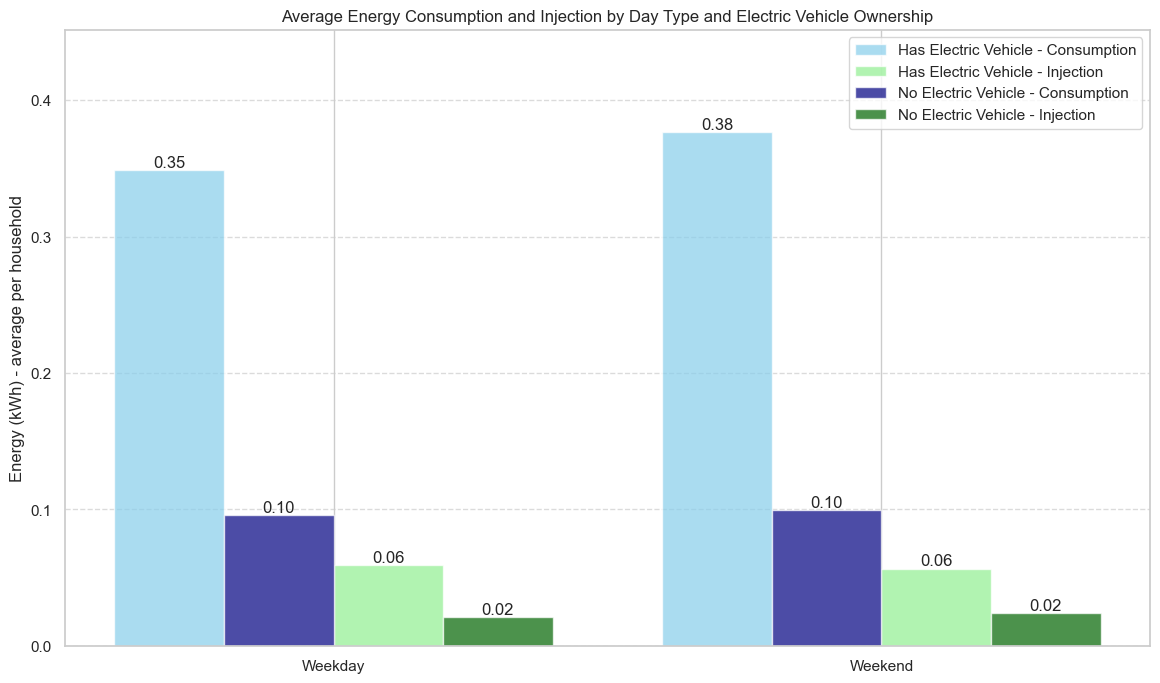

On Weekdays, No Electric Vehicle mean -72.5% less electricity than Has Electric Vehicle
On Weekends, No Electric Vehicle mean -73.6% less electricity than Has Electric Vehicle


In [19]:
# Show average energy by Electric_Vehicle_Indicator
analyze_weekday_weekend_by_indicator(df, 'Electric_Vehicle_Indicator', 'mean')


Total Weekend vs Weekday Energy by Electric Vehicle Ownership:


,Weekday_Weekend,Electric_Vehicle_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
0,Weekday,0,8868.585671,1955.639000,4,No Electric Vehicle
1,Weekday,1,17403.799457,2950.609974,2,Has Electric Vehicle
2,Weekend,0,3710.600571,897.078000,4,No Electric Vehicle
3,Weekend,1,7588.081000,1141.377000,2,Has Electric Vehicle


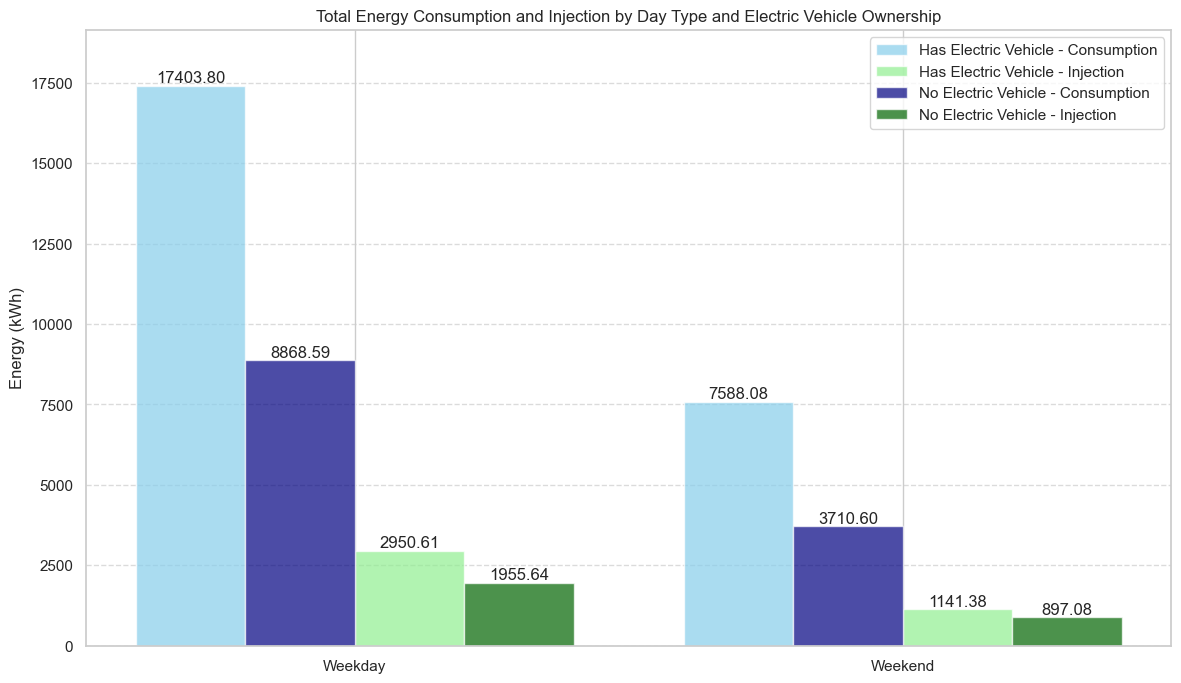

On Weekdays, No Electric Vehicle sum -49.0% less electricity than Has Electric Vehicle
On Weekends, No Electric Vehicle sum -51.1% less electricity than Has Electric Vehicle


In [20]:
# Show average energy by Electric_Vehicle_Indicator
analyze_weekday_weekend_by_indicator(df, 'Electric_Vehicle_Indicator', 'sum')


Average Weekend vs Weekday Energy by Solar Panel Ownership:


,Weekday_Weekend,PV_Installation_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
0,Weekday,0,0.202988,0.000000,4,No Solar Panel
1,Weekday,1,0.140802,0.115019,2,Has Solar Panel
2,Weekend,0,0.214314,0.000000,4,No Solar Panel
3,Weekend,1,0.154652,0.118625,2,Has Solar Panel


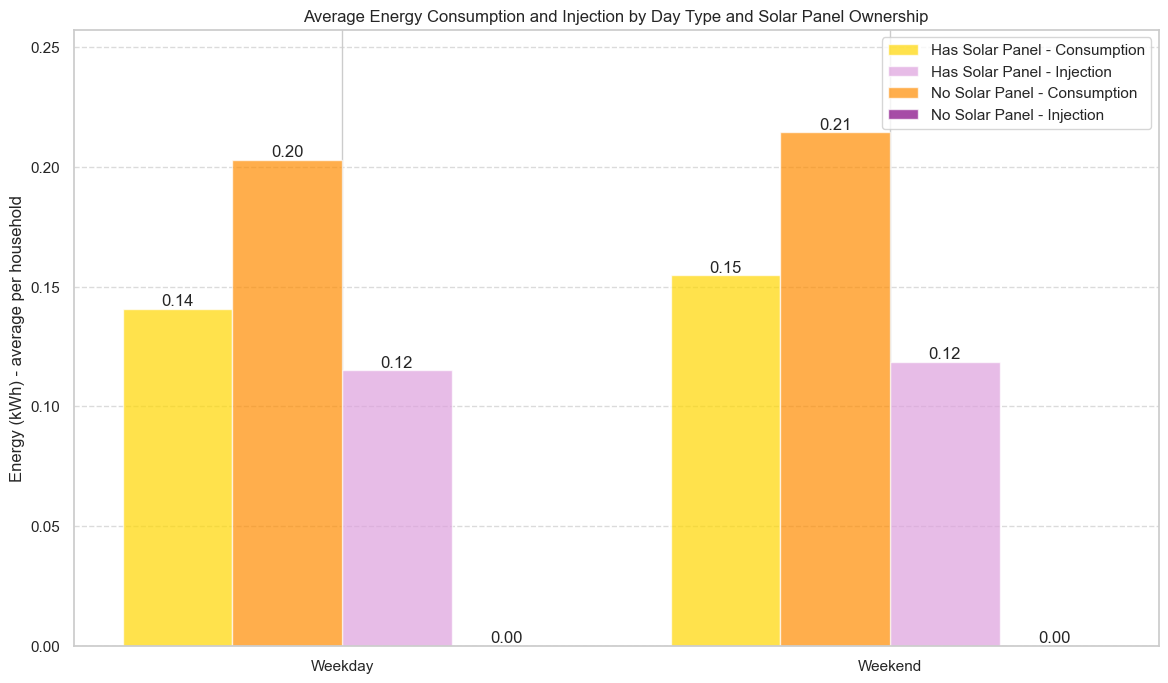

On Weekdays, No Solar Panel mean 44.2% more electricity than Has Solar Panel
On Weekends, No Solar Panel mean 38.6% more electricity than Has Solar Panel


In [21]:
# Show average energy by PV_Installation_Indicator
analyze_weekday_weekend_by_indicator(df, 'PV_Installation_Indicator', 'mean')


Total Weekend vs Weekday Energy by Solar Panel Ownership:


,Weekday_Weekend,PV_Installation_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
0,Weekday,0,20266.338671,0.000000,4,No Solar Panel
1,Weekday,1,6006.046457,4906.248974,2,Has Solar Panel
2,Weekend,0,8641.145571,0.000000,4,No Solar Panel
3,Weekend,1,2657.536000,2038.455000,2,Has Solar Panel


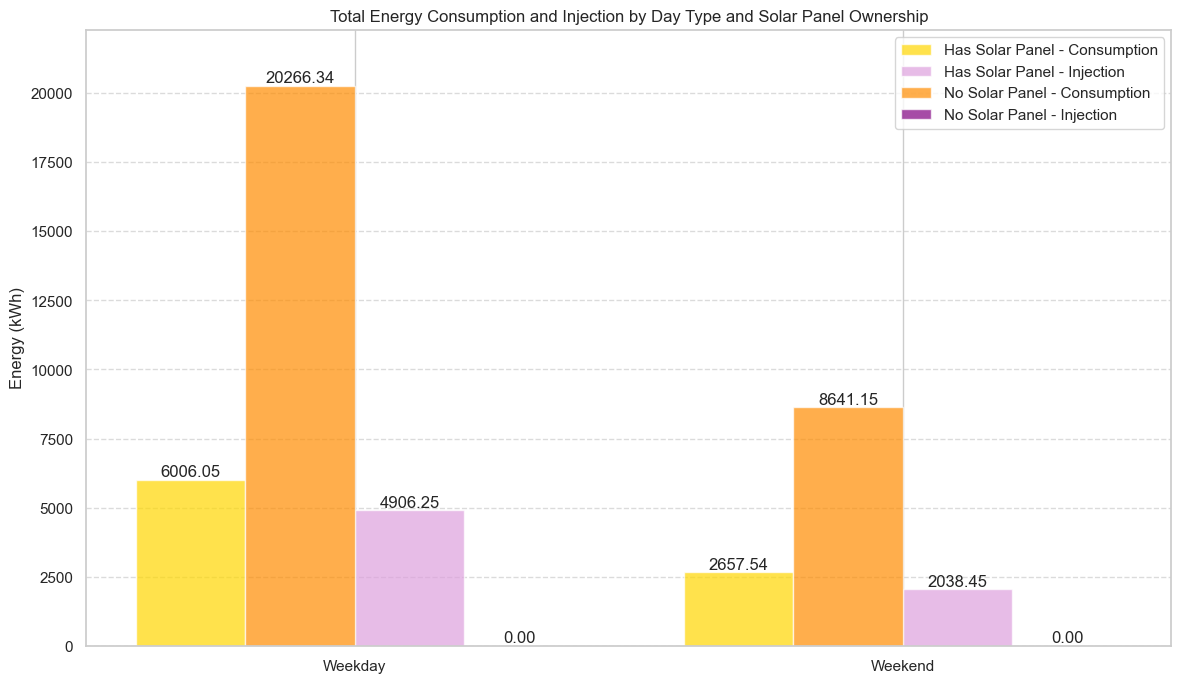

On Weekdays, No Solar Panel sum 237.4% more electricity than Has Solar Panel
On Weekends, No Solar Panel sum 225.2% more electricity than Has Solar Panel


In [23]:
# Show average energy by PV_Installation_Indicator
analyze_weekday_weekend_by_indicator(df, 'PV_Installation_Indicator', 'sum')


Average Weekend vs Weekday Energy by Heat Pump Ownership:


,Weekday_Weekend,Heat_Pump_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
0,Weekday,0,0.184373,0.034431,6,No Heat Pump
1,Weekend,0,0.196485,0.035449,6,No Heat Pump


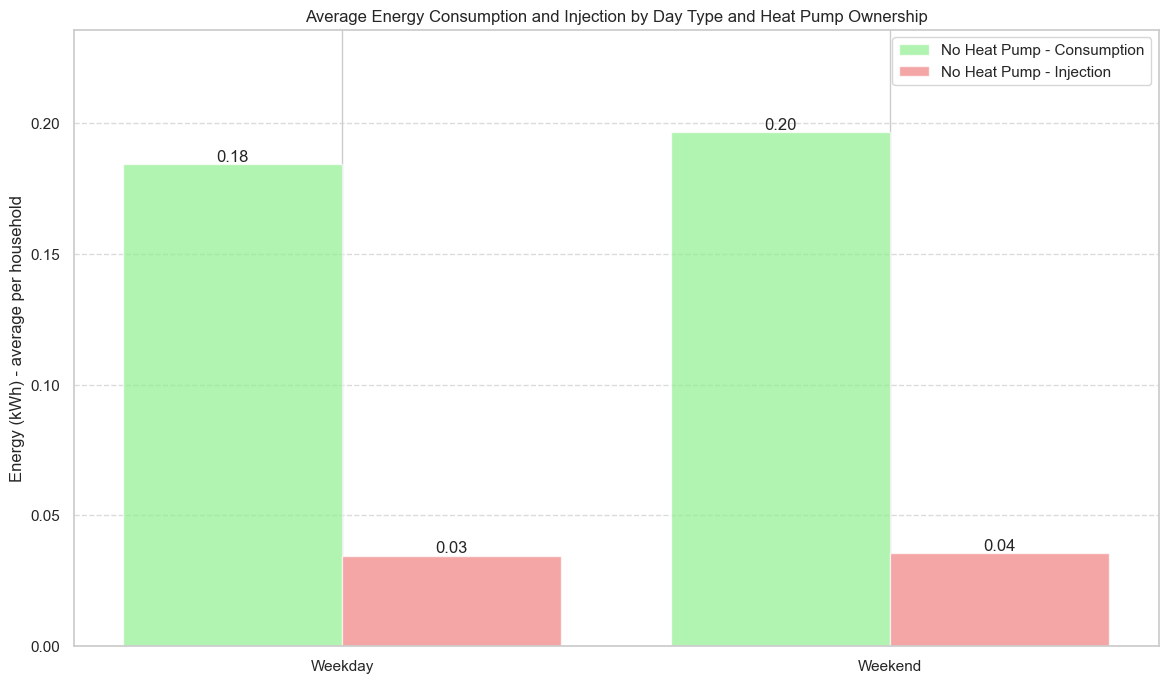

Only one heat pump status present in data, no comparison possible


In [24]:
# Show average energy by Heat_Pump_Indicator
analyze_weekday_weekend_by_indicator(df, 'Heat_Pump_Indicator', 'mean')


Total Weekend vs Weekday Energy by Heat Pump Ownership:


,Weekday_Weekend,Heat_Pump_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
0,Weekday,0,26272.385128,4906.248974,6,No Heat Pump
1,Weekend,0,11298.681571,2038.455000,6,No Heat Pump


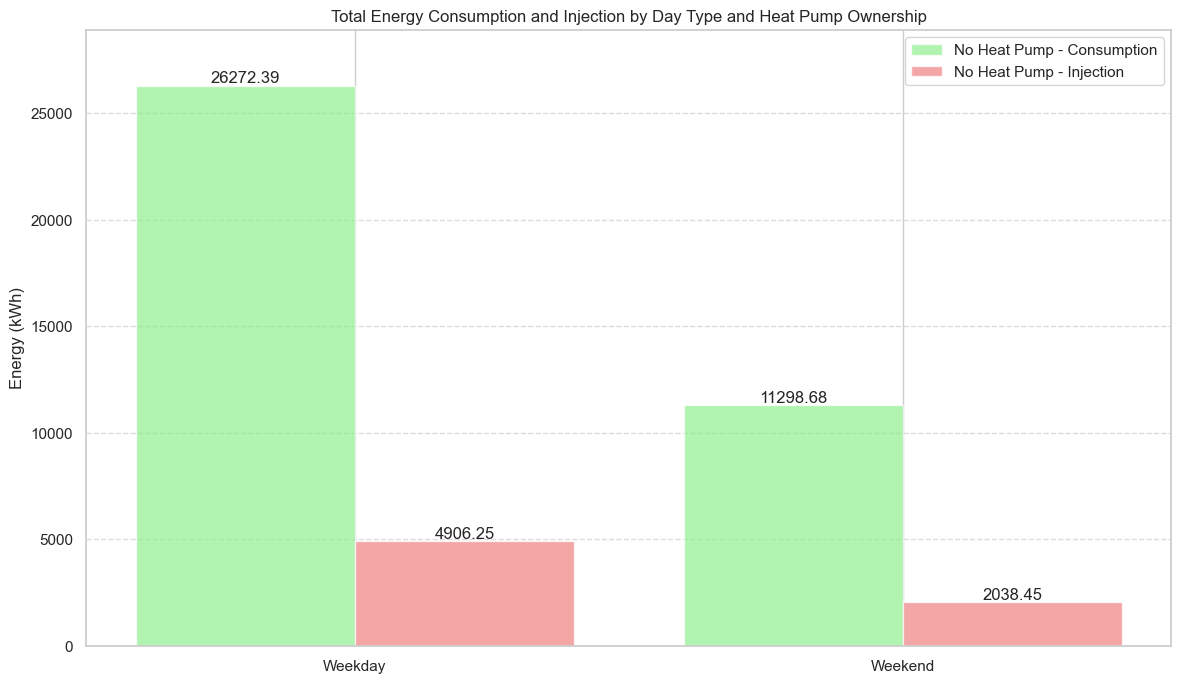

Only one heat pump status present in data, no comparison possible


In [25]:
# Show average energy by Heat_Pump_Indicator
analyze_weekday_weekend_by_indicator(df, 'Heat_Pump_Indicator', 'sum')


# 3. Time Serie (Daily) vs 5 combinations

In [29]:
def analyze_daily_by_indicator(df, indicator_column, aggregation_method='sum'):
    """
    Analyze daily consumption patterns by a binary indicator (0/1).
    
    Parameters:
    - df: DataFrame containing the data
    - indicator_column: Name of the column with binary indicator (e.g., 'Electric_Vehicle_Indicator')
    - aggregation_method: Method to aggregate energy values ('sum' or 'mean')
    """
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    
    if indicator_column not in df.columns:
        print(f"{indicator_column} not found in the dataset")
        return
    
    # Map indicator names to feature names and colors
    indicator_mapping = {
        'Electric_Vehicle_Indicator': {'name': 'Electric Vehicle', 
                                      'colors': ['blue', 'red']},
        'Heat_Pump_Indicator': {'name': 'Heat Pump', 
                               'colors': ['green', 'purple']},
        'PV_Installation_Indicator': {'name': 'Solar Panel', 
                                     'colors': ['orange', 'brown']}
    }
    
    # Get feature info or create default
    feature_info = indicator_mapping.get(indicator_column, {
        'name': indicator_column.replace('_Indicator', '').replace('_', ' '),
        'colors': ['blue', 'red']
    })
    
    feature_name = feature_info['name']
    colors = feature_info['colors']
        
    # Validate aggregation method
    if aggregation_method not in ['sum', 'mean']:
        print(f"Invalid aggregation method: {aggregation_method}. Using 'sum' instead.")
        aggregation_method = 'sum'
    
    # Group by both Day_Name and the indicator
    combined_agg = df.groupby(['Day_Name', indicator_column]).agg({
        'Volume_Consumption_kWh': aggregation_method,
        'Volume_Injection_kWh': aggregation_method,
        'EAN_ID': 'nunique'  # Count unique households
    }).reset_index()
    
    # Create a mapping dictionary based on available values
    index_mapping = {}
    if 0 in combined_agg[indicator_column].unique():
        index_mapping[0] = f'No {feature_name}'
    if 1 in combined_agg[indicator_column].unique():
        index_mapping[1] = f'Has {feature_name}'
    
    # Apply mapping to create a new readable column
    combined_agg['Status'] = combined_agg[indicator_column].map(
        lambda x: index_mapping.get(x, f'Value {x}')
    )
    
    # Ensure days of week are in order
    day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    combined_agg['Day_Order'] = combined_agg['Day_Name'].map(lambda x: day_order.index(x) if x in day_order else 7)
    combined_agg = combined_agg.sort_values(['Status', 'Day_Order'])
    
    agg_display_name = "Total" if aggregation_method == 'sum' else "Average"
    print(f"{agg_display_name} Daily Energy by {feature_name} Ownership:")
    display(combined_agg.drop('Day_Order', axis=1))
    
    # Create a single plot
    plt.figure(figsize=(14, 8))
    
    # Get unique statuses
    status_values = combined_agg['Status'].unique()
    
    # Track max height for y-axis scaling
    max_value = 0
    
    # Plot all lines on the same graph
    for i, status in enumerate(sorted(status_values)):
        status_data = combined_agg[combined_agg['Status'] == status]
        color = colors[i % len(colors)]
        
        # Plot consumption (solid line)
        plt.plot(status_data['Day_Name'], status_data['Volume_Consumption_kWh'], 
                marker='o', linewidth=3, markersize=8, 
                color=color, linestyle='-',
                label=f'{status} - Consumption')
        
        # Plot injection (dashed line)
        plt.plot(status_data['Day_Name'], status_data['Volume_Injection_kWh'], 
                marker='s', linewidth=3, markersize=8, 
                color=color, linestyle='--',
                label=f'{status} - Injection')
        
        # Update max value
        max_value = max(max_value, 
                      status_data['Volume_Consumption_kWh'].max(), 
                      status_data['Volume_Injection_kWh'].max())
        
        # Add value labels for consumption
        for x, y in zip(status_data['Day_Name'], status_data['Volume_Consumption_kWh']):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
        
        # Add value labels for injection
        for x, y in zip(status_data['Day_Name'], status_data['Volume_Injection_kWh']):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom')
    
    # Set title and labels
    plt.title(f'{agg_display_name} Energy by Day and {feature_name} Ownership')
    
    energy_label = f'Energy (kWh) - {agg_display_name.lower()} per household' if aggregation_method == 'mean' else 'Energy (kWh)'
    plt.ylabel(energy_label)
    
    # Set x ticks
    plt.xticks(range(len(day_order)), day_order)
    
    # Set proper y-limit
    y_pad = 1.2 if aggregation_method == 'mean' else 1.1  # 20% padding for mean, 10% for sum
    plt.ylim(0, max_value * y_pad)
    
    # Add grid and legend
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    
    # Create snake_case filename
    filename = f"daily_{aggregation_method}_by_{feature_name.lower().replace(' ', '_')}"
    plt.savefig(f'analysis_results/{filename}.png', dpi=300)
    plt.show()
    
    # Calculate comparisons if possible
    if len(status_values) > 1:
        for day in day_order:
            status_data = {}
            for status in status_values:
                data = combined_agg[(combined_agg['Day_Name'] == day) & 
                                   (combined_agg['Status'] == status)]
                if not data.empty:
                    status_data[status] = data
            
            # If we have data for multiple statuses, calculate difference
            if len(status_data) > 1:
                status_pairs = list(itertools.combinations(status_values, 2))
                for status1, status2 in status_pairs:
                    if status1 in status_data and status2 in status_data:
                        consumption_diff = (status_data[status1]['Volume_Consumption_kWh'].values[0] / 
                                          status_data[status2]['Volume_Consumption_kWh'].values[0] - 1) * 100
                        print(f"On {day}s, {status1} {aggregation_method} {consumption_diff:.1f}% " + 
                              f"{'more' if consumption_diff > 0 else 'less'} electricity than {status2}")
    else:
        print(f"Only one {feature_name.lower()} status present in data, no comparison possible")

Total Daily Energy by Electric Vehicle Ownership:


,Day_Name,Electric_Vehicle_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
3,Monday,1,3607.306000,571.666000,2,Has Electric Vehicle
11,Tuesday,1,3310.114000,619.269000,2,Has Electric Vehicle
13,Wednesday,1,3554.631863,603.223000,2,Has Electric Vehicle
9,Thursday,1,3315.008594,591.277974,2,Has Electric Vehicle
1,Friday,1,3616.739000,565.174000,2,Has Electric Vehicle
5,Saturday,1,3906.467000,604.322000,2,Has Electric Vehicle
7,Sunday,1,3681.614000,537.055000,2,Has Electric Vehicle
2,Monday,0,1817.168000,367.424000,4,No Electric Vehicle
10,Tuesday,0,1675.660000,366.776000,4,No Electric Vehicle
12,Wednesday,0,1984.540996,375.541000,4,No Electric Vehicle


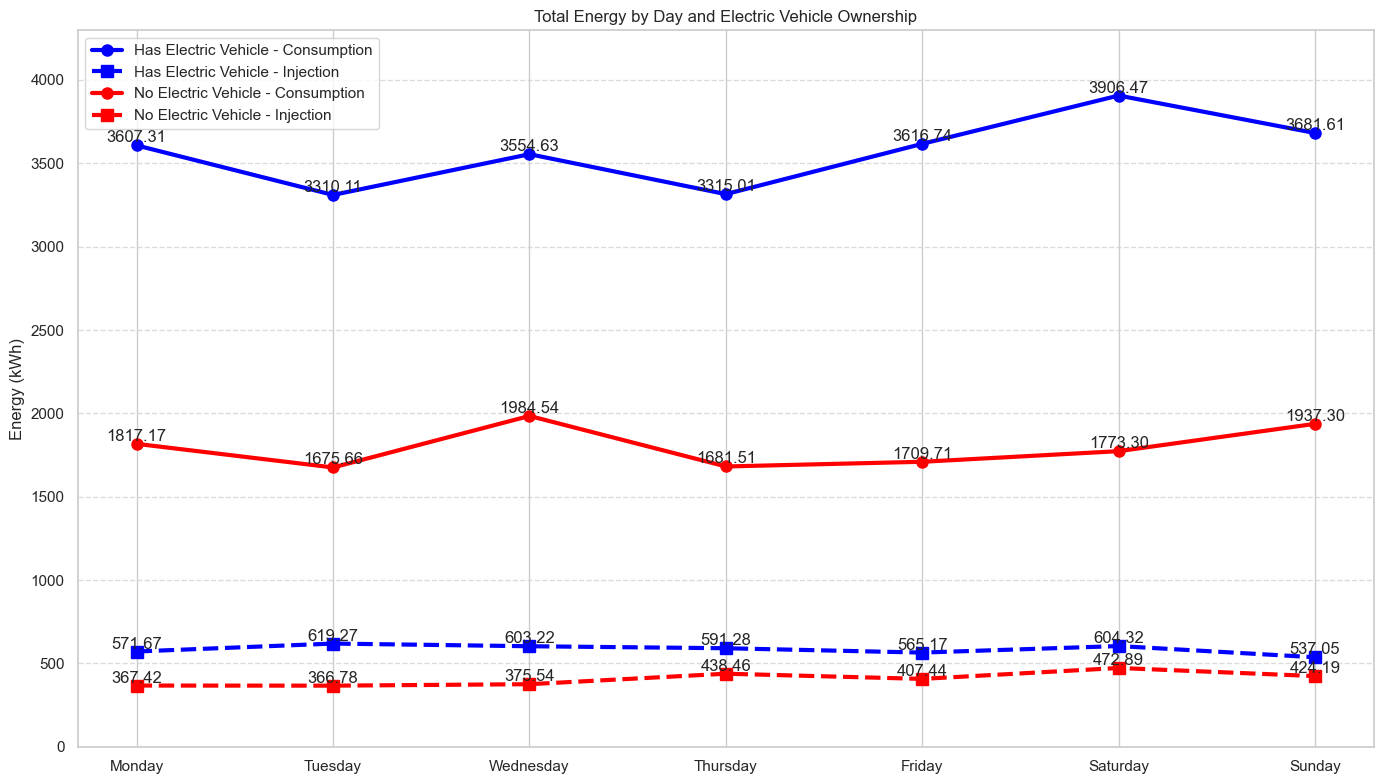

On Mondays, Has Electric Vehicle sum 98.5% more electricity than No Electric Vehicle
On Tuesdays, Has Electric Vehicle sum 97.5% more electricity than No Electric Vehicle
On Wednesdays, Has Electric Vehicle sum 79.1% more electricity than No Electric Vehicle
On Thursdays, Has Electric Vehicle sum 97.1% more electricity than No Electric Vehicle
On Fridays, Has Electric Vehicle sum 111.5% more electricity than No Electric Vehicle
On Saturdays, Has Electric Vehicle sum 120.3% more electricity than No Electric Vehicle
On Sundays, Has Electric Vehicle sum 90.0% more electricity than No Electric Vehicle


In [ ]:
# Analyze daily patterns by Electric Vehicle ownership (mean)
analyze_daily_by_indicator(df, 'Electric_Vehicle_Indicator', 'mean')


Average Daily Energy by Heat Pump Ownership:


,Day_Name,Heat_Pump_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
1,Monday,0,0.190252,0.032937,6,No Heat Pump
5,Tuesday,0,0.174866,0.034584,6,No Heat Pump
6,Wednesday,0,0.194275,0.034328,6,No Heat Pump
4,Thursday,0,0.175243,0.036116,6,No Heat Pump
0,Friday,0,0.187235,0.034189,6,No Heat Pump
2,Saturday,0,0.195908,0.037155,6,No Heat Pump
3,Sunday,0,0.197072,0.033714,6,No Heat Pump


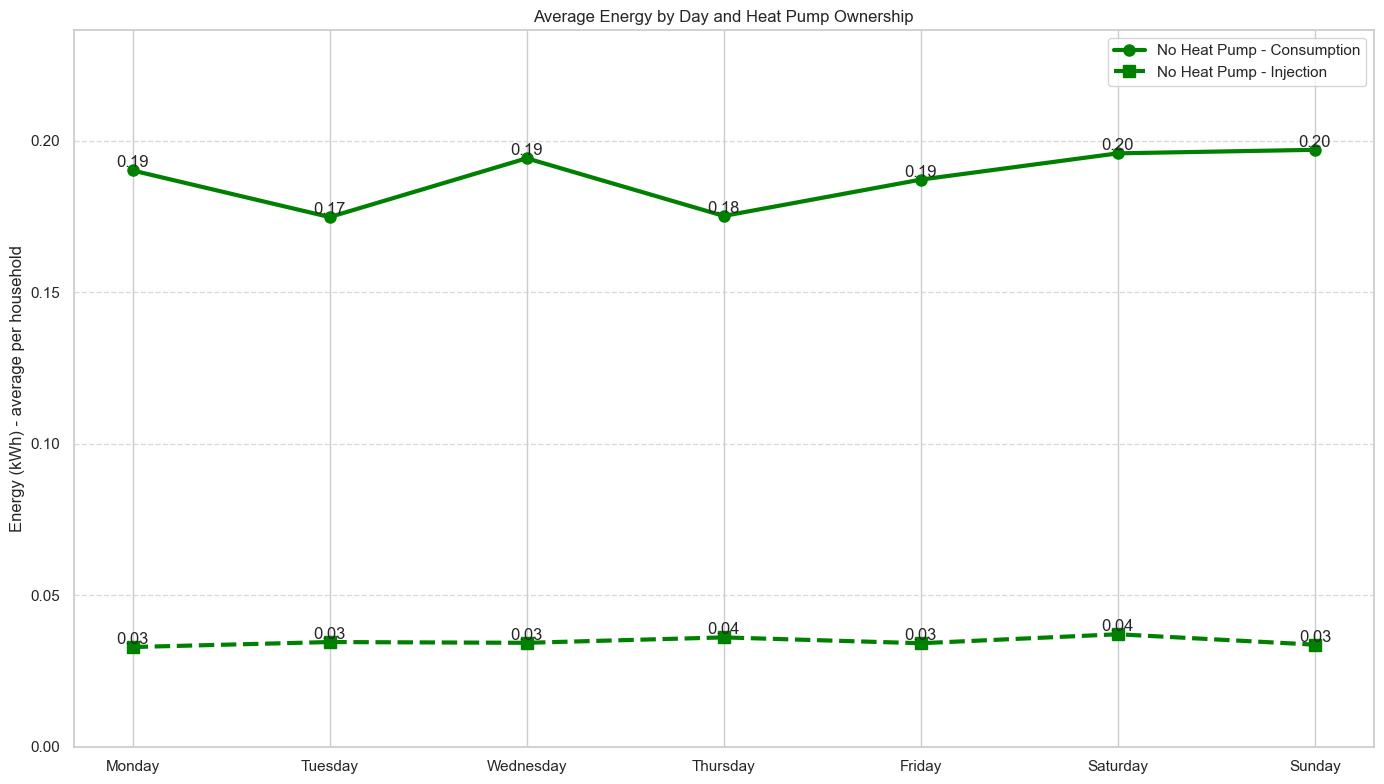

Only one heat pump status present in data, no comparison possible


In [32]:
# Analyze daily patterns by Heat_Pump_Indicator (mean)
analyze_daily_by_indicator(df, 'Heat_Pump_Indicator', 'mean')

Average Daily Energy by Solar Panel Ownership:


,Day_Name,PV_Installation_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status
3,Monday,1,0.158677,0.109912,2,Has Solar Panel
11,Tuesday,1,0.135026,0.115408,2,Has Solar Panel
13,Wednesday,1,0.138498,0.114556,2,Has Solar Panel
9,Thursday,1,0.134409,0.120522,2,Has Solar Panel
1,Friday,1,0.137373,0.114694,2,Has Solar Panel
5,Saturday,1,0.149307,0.124677,2,Has Solar Panel
7,Sunday,1,0.160056,0.112505,2,Has Solar Panel
2,Monday,0,0.203763,0.000000,4,No Solar Panel
10,Tuesday,0,0.191913,0.000000,4,No Solar Panel
12,Wednesday,0,0.218141,0.000000,4,No Solar Panel


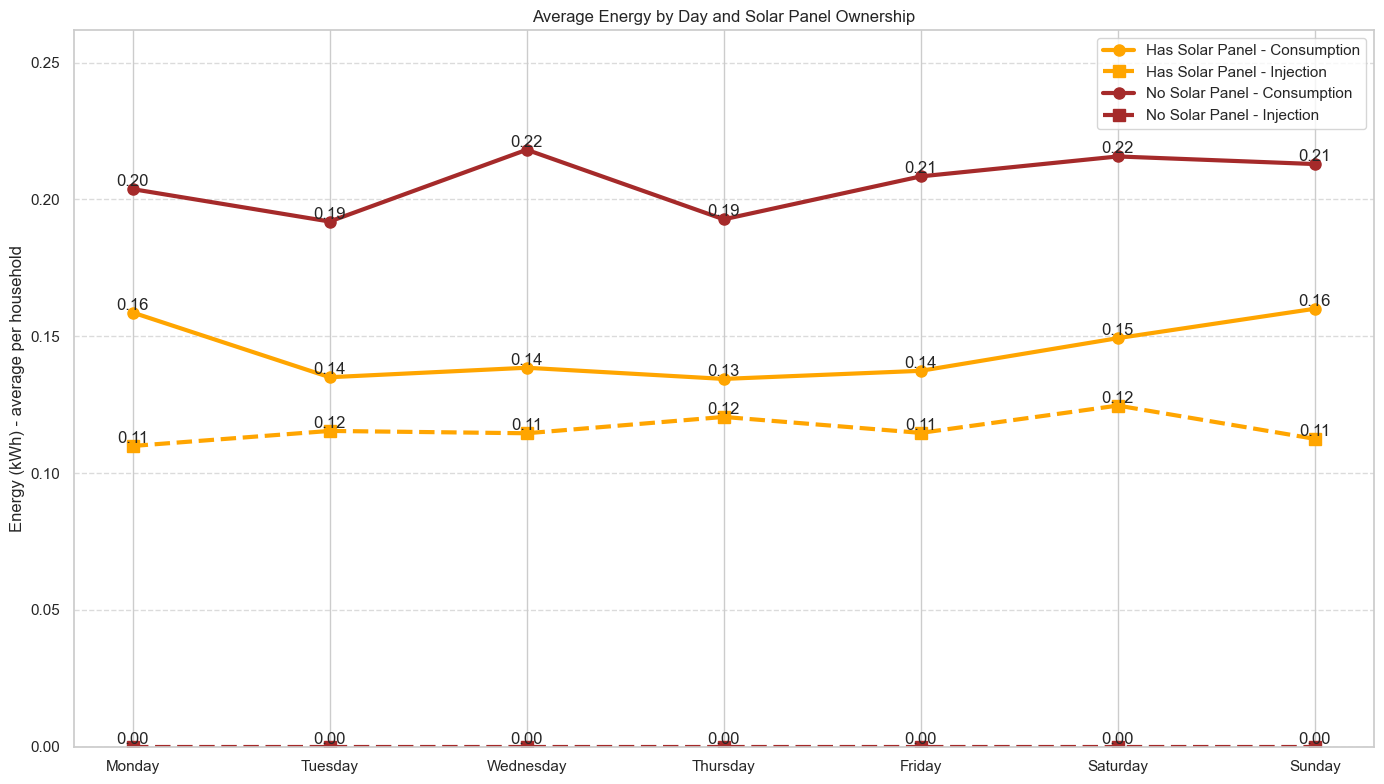

On Mondays, Has Solar Panel mean -22.1% less electricity than No Solar Panel
On Tuesdays, Has Solar Panel mean -29.6% less electricity than No Solar Panel
On Wednesdays, Has Solar Panel mean -36.5% less electricity than No Solar Panel
On Thursdays, Has Solar Panel mean -30.3% less electricity than No Solar Panel
On Fridays, Has Solar Panel mean -34.1% less electricity than No Solar Panel
On Saturdays, Has Solar Panel mean -30.8% less electricity than No Solar Panel
On Sundays, Has Solar Panel mean -24.8% less electricity than No Solar Panel


In [33]:
# Analyze daily patterns by PV_Installation_Indicator (mean)
analyze_daily_by_indicator(df, 'PV_Installation_Indicator', 'mean')

# 4. Time Serie (Monthly) vs 5 combinations

In [34]:
def analyze_monthly_by_indicator(df, indicator_column, aggregation_method='sum'):
    """
    Analyze monthly consumption patterns by a binary indicator (0/1).
    
    Parameters:
    - df: DataFrame containing the data
    - indicator_column: Name of the column with binary indicator (e.g., 'Electric_Vehicle_Indicator')
    - aggregation_method: Method to aggregate energy values ('sum' or 'mean')
    """
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    
    if indicator_column not in df.columns:
        print(f"{indicator_column} not found in the dataset")
        return
    
    # Map indicator names to feature names and colors
    indicator_mapping = {
        'Electric_Vehicle_Indicator': {'name': 'Electric Vehicle', 
                                      'colors': ['blue', 'red']},
        'Heat_Pump_Indicator': {'name': 'Heat Pump', 
                               'colors': ['green', 'purple']},
        'PV_Installation_Indicator': {'name': 'Solar Panel', 
                                     'colors': ['orange', 'brown']}
    }
    
    # Get feature info or create default
    feature_info = indicator_mapping.get(indicator_column, {
        'name': indicator_column.replace('_Indicator', '').replace('_', ' '),
        'colors': ['blue', 'red']
    })
    
    feature_name = feature_info['name']
    colors = feature_info['colors']
        
    # Validate aggregation method
    if aggregation_method not in ['sum', 'mean']:
        print(f"Invalid aggregation method: {aggregation_method}. Using 'sum' instead.")
        aggregation_method = 'sum'
    
    # Group by Year, Month and the indicator
    combined_agg = df.groupby(['Year', 'Month', indicator_column]).agg({
        'Volume_Consumption_kWh': aggregation_method,
        'Volume_Injection_kWh': aggregation_method,
        'EAN_ID': 'nunique'  # Count unique households
    }).reset_index()
    
    # Create a mapping dictionary based on available values
    index_mapping = {}
    if 0 in combined_agg[indicator_column].unique():
        index_mapping[0] = f'No {feature_name}'
    if 1 in combined_agg[indicator_column].unique():
        index_mapping[1] = f'Has {feature_name}'
    
    # Apply mapping to create a new readable column
    combined_agg['Status'] = combined_agg[indicator_column].map(
        lambda x: index_mapping.get(x, f'Value {x}')
    )
    
    # Add month name for better readability and create period column
    month_names = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun', 
                  7:'Jul', 8:'Aug', 9:'Sep', 10:'Oct', 11:'Nov', 12:'Dec'}
    combined_agg['Month_Name'] = combined_agg['Month'].map(month_names)
    combined_agg['Period'] = combined_agg['Year'].astype(str) + '-' + combined_agg['Month_Name']
    
    # Sort by Year, Month and Status for consistent ordering
    combined_agg['Month_Order'] = combined_agg['Year'] * 100 + combined_agg['Month']
    combined_agg = combined_agg.sort_values(['Status', 'Month_Order'])
    
    agg_display_name = "Total" if aggregation_method == 'sum' else "Average"
    print(f"{agg_display_name} Monthly Energy by {feature_name} Ownership:")
    display(combined_agg.drop(['Month_Order'], axis=1))
    
    # Create a single plot
    plt.figure(figsize=(16, 8))
    
    # Get unique statuses
    status_values = combined_agg['Status'].unique()
    
    # Track max height for y-axis scaling
    max_value = 0
    
    # Plot all lines on the same graph
    for i, status in enumerate(sorted(status_values)):
        status_data = combined_agg[combined_agg['Status'] == status]
        color = colors[i % len(colors)]
        
        # Plot consumption (solid line)
        plt.plot(status_data['Period'], status_data['Volume_Consumption_kWh'], 
                marker='o', linewidth=3, markersize=8, 
                color=color, linestyle='-',
                label=f'{status} - Consumption')
        
        # Plot injection (dashed line)
        plt.plot(status_data['Period'], status_data['Volume_Injection_kWh'], 
                marker='s', linewidth=3, markersize=8, 
                color=color, linestyle='--',
                label=f'{status} - Injection')
        
        # Update max value
        max_value = max(max_value, 
                      status_data['Volume_Consumption_kWh'].max(), 
                      status_data['Volume_Injection_kWh'].max())
        
        # Add value labels for consumption
        for x, y in zip(status_data['Period'], status_data['Volume_Consumption_kWh']):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', rotation=45, fontsize=8)
        
        # Add value labels for injection
        for x, y in zip(status_data['Period'], status_data['Volume_Injection_kWh']):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', rotation=45, fontsize=8)
    
    # Set title and labels
    plt.title(f'{agg_display_name} Energy by Month and {feature_name} Ownership')
    
    energy_label = f'Energy (kWh) - {agg_display_name.lower()} per household' if aggregation_method == 'mean' else 'Energy (kWh)'
    plt.ylabel(energy_label)
    plt.xlabel('Month')
    
    # Rotate x labels
    plt.xticks(rotation=45)
    
    # Set proper y-limit
    y_pad = 1.2 if aggregation_method == 'mean' else 1.1  # 20% padding for mean, 10% for sum
    plt.ylim(0, max_value * y_pad)
    
    # Add grid and legend
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    
    # Create snake_case filename
    filename = f"monthly_{aggregation_method}_by_{feature_name.lower().replace(' ', '_')}"
    plt.savefig(f'analysis_results/{filename}.png', dpi=300)
    plt.show()
    
    # Calculate monthly comparisons if possible
    if len(status_values) > 1:
        # Group periods by month (regardless of year)
        for month, month_name in month_names.items():
            status_data = {}
            for status in status_values:
                data = combined_agg[(combined_agg['Month'] == month) & 
                                  (combined_agg['Status'] == status)]
                
                if not data.empty:
                    # Aggregate across years if there are multiple years for the same month
                    agg_data = data.groupby('Status').agg({
                        'Volume_Consumption_kWh': 'mean',
                        'Volume_Injection_kWh': 'mean'
                    }).reset_index()
                    status_data[status] = agg_data
            
            # If we have data for multiple statuses, calculate difference
            if len(status_data) > 1:
                status_pairs = list(itertools.combinations(status_values, 2))
                for status1, status2 in status_pairs:
                    if status1 in status_data and status2 in status_data:
                        s1_data = status_data[status1]
                        s2_data = status_data[status2]
                        consumption_diff = (s1_data['Volume_Consumption_kWh'].values[0] / 
                                          s2_data['Volume_Consumption_kWh'].values[0] - 1) * 100
                        print(f"In {month_name}, {status1} {aggregation_method} {consumption_diff:.1f}% " + 
                              f"{'more' if consumption_diff > 0 else 'less'} electricity than {status2}")
    else:
        print(f"Only one {feature_name.lower()} status present in data, no comparison possible")

Average Monthly Energy by Electric Vehicle Ownership:


,Year,Month,Electric_Vehicle_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Month_Name,Period
1,2022,1,1,0.365963,0.007410,2,Has Electric Vehicle,Jan,2022-Jan
3,2022,2,1,0.593917,0.020916,2,Has Electric Vehicle,Feb,2022-Feb
5,2022,3,1,0.469634,0.069237,2,Has Electric Vehicle,Mar,2022-Mar
7,2022,4,1,0.365173,0.065194,2,Has Electric Vehicle,Apr,2022-Apr
9,2022,5,1,0.411430,0.092172,2,Has Electric Vehicle,May,2022-May
11,2022,6,1,0.398046,0.100270,2,Has Electric Vehicle,Jun,2022-Jun
13,2022,7,1,0.391814,0.105451,2,Has Electric Vehicle,Jul,2022-Jul
15,2022,8,1,0.192799,0.104552,2,Has Electric Vehicle,Aug,2022-Aug
17,2022,9,1,0.257141,0.059855,2,Has Electric Vehicle,Sep,2022-Sep
19,2022,10,1,0.236844,0.046197,2,Has Electric Vehicle,Oct,2022-Oct


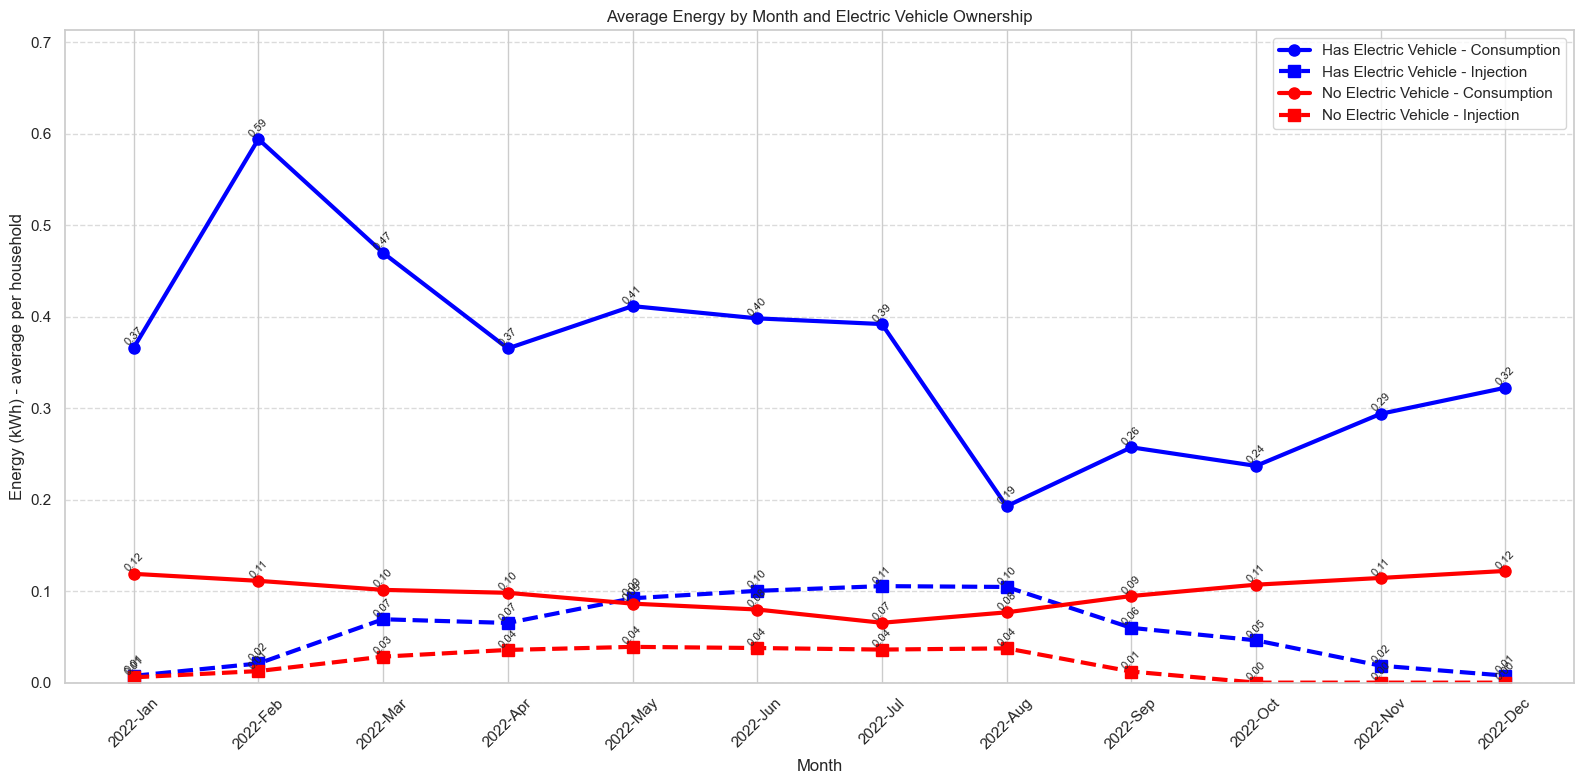

In Jan, Has Electric Vehicle mean 207.9% more electricity than No Electric Vehicle
In Feb, Has Electric Vehicle mean 434.0% more electricity than No Electric Vehicle
In Mar, Has Electric Vehicle mean 363.4% more electricity than No Electric Vehicle
In Apr, Has Electric Vehicle mean 272.2% more electricity than No Electric Vehicle
In May, Has Electric Vehicle mean 376.6% more electricity than No Electric Vehicle
In Jun, Has Electric Vehicle mean 398.2% more electricity than No Electric Vehicle
In Jul, Has Electric Vehicle mean 499.2% more electricity than No Electric Vehicle
In Aug, Has Electric Vehicle mean 151.0% more electricity than No Electric Vehicle
In Sep, Has Electric Vehicle mean 171.7% more electricity than No Electric Vehicle
In Oct, Has Electric Vehicle mean 121.3% more electricity than No Electric Vehicle
In Nov, Has Electric Vehicle mean 156.8% more electricity than No Electric Vehicle
In Dec, Has Electric Vehicle mean 164.0% more electricity than No Electric Vehicle


In [35]:
analyze_monthly_by_indicator(df, 'Electric_Vehicle_Indicator', 'mean')

Average Monthly Energy by Heat Pump Ownership:


,Year,Month,Heat_Pump_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Month_Name,Period
0,2022,1,0,0.201238,0.006330,6,No Heat Pump,Jan,2022-Jan
1,2022,2,0,0.272122,0.015381,6,No Heat Pump,Feb,2022-Feb
2,2022,3,0,0.224115,0.042009,6,No Heat Pump,Mar,2022-Mar
3,2022,4,0,0.187137,0.045542,6,No Heat Pump,Apr,2022-Apr
4,2022,5,0,0.194688,0.056774,6,No Heat Pump,May,2022-May
5,2022,6,0,0.185947,0.058623,6,No Heat Pump,Jun,2022-Jun
6,2022,7,0,0.174200,0.059230,6,No Heat Pump,Jul,2022-Jul
7,2022,8,0,0.115472,0.059809,6,No Heat Pump,Aug,2022-Aug
8,2022,9,0,0.153618,0.029439,6,No Heat Pump,Sep,2022-Sep
9,2022,10,0,0.158952,0.018479,5,No Heat Pump,Oct,2022-Oct


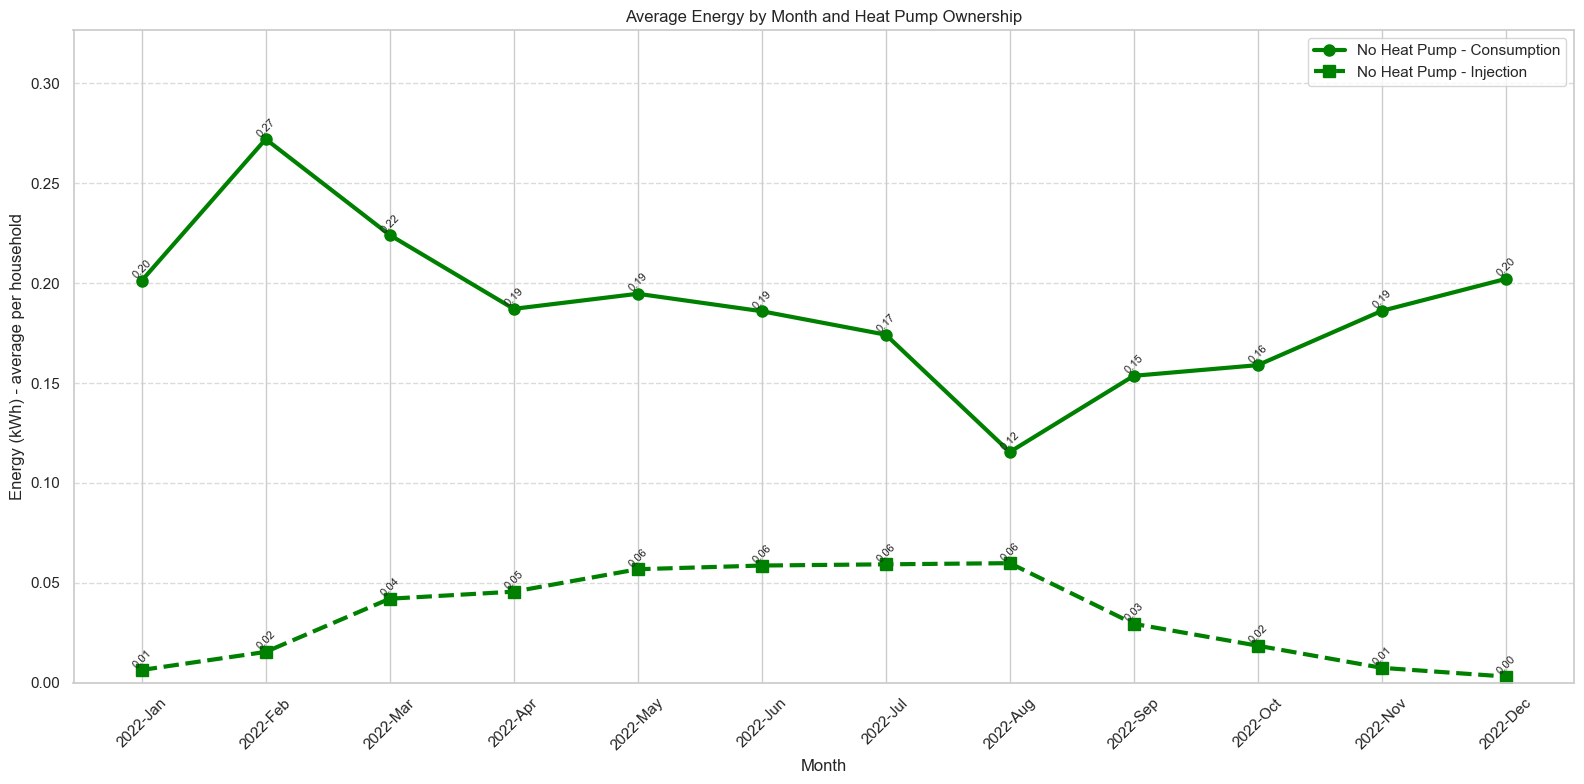

Only one heat pump status present in data, no comparison possible


In [36]:
analyze_monthly_by_indicator(df, 'Heat_Pump_Indicator', 'mean')


Average Monthly Energy by Solar Panel Ownership:


,Year,Month,PV_Installation_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Month_Name,Period
1,2022,1,1,0.237107,0.018990,2,Has Solar Panel,Jan,2022-Jan
3,2022,2,1,0.233053,0.046144,2,Has Solar Panel,Feb,2022-Feb
5,2022,3,1,0.157580,0.126026,2,Has Solar Panel,Mar,2022-Mar
7,2022,4,1,0.140156,0.136626,2,Has Solar Panel,Apr,2022-Apr
9,2022,5,1,0.091041,0.170321,2,Has Solar Panel,May,2022-May
11,2022,6,1,0.072063,0.175870,2,Has Solar Panel,Jun,2022-Jun
13,2022,7,1,0.066996,0.177689,2,Has Solar Panel,Jul,2022-Jul
15,2022,8,1,0.063976,0.179428,2,Has Solar Panel,Aug,2022-Aug
17,2022,9,1,0.131517,0.107365,2,Has Solar Panel,Sep,2022-Sep
19,2022,10,1,0.178482,0.092394,1,Has Solar Panel,Oct,2022-Oct


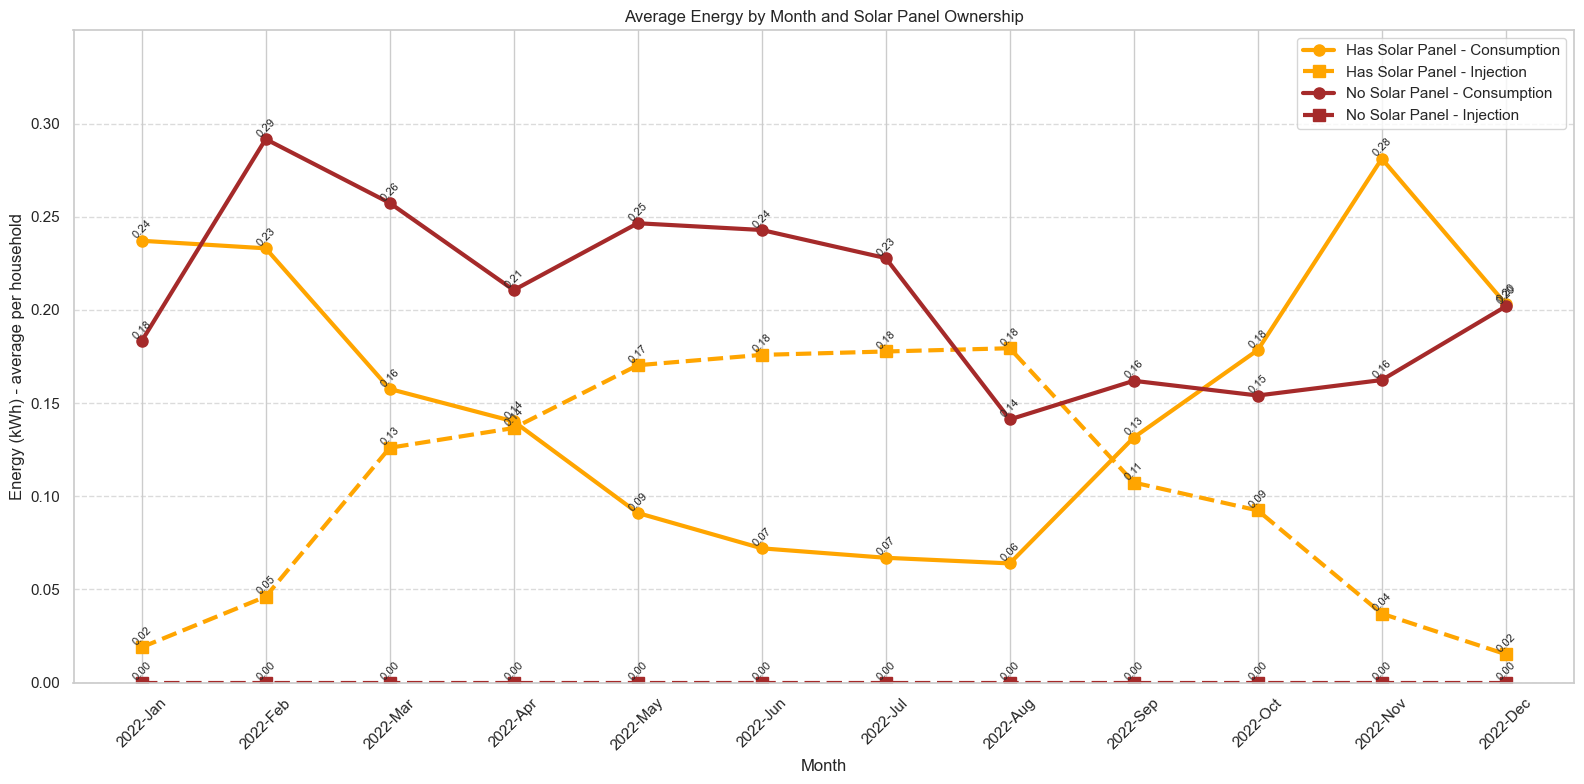

In Jan, Has Solar Panel mean 29.4% more electricity than No Solar Panel
In Feb, Has Solar Panel mean -20.1% less electricity than No Solar Panel
In Mar, Has Solar Panel mean -38.8% less electricity than No Solar Panel
In Apr, Has Solar Panel mean -33.5% less electricity than No Solar Panel
In May, Has Solar Panel mean -63.1% less electricity than No Solar Panel
In Jun, Has Solar Panel mean -70.3% less electricity than No Solar Panel
In Jul, Has Solar Panel mean -70.6% less electricity than No Solar Panel
In Aug, Has Solar Panel mean -54.7% less electricity than No Solar Panel
In Sep, Has Solar Panel mean -18.8% less electricity than No Solar Panel
In Oct, Has Solar Panel mean 15.8% more electricity than No Solar Panel
In Nov, Has Solar Panel mean 73.2% more electricity than No Solar Panel
In Dec, Has Solar Panel mean 0.6% more electricity than No Solar Panel


In [37]:
analyze_monthly_by_indicator(df, 'PV_Installation_Indicator', 'mean')


# 5. Time Serie (Quarterly) vs 5 combinations

In [38]:
def analyze_quarterly_by_indicator(df, indicator_column, aggregation_method='sum'):
    """
    Analyze quarterly consumption patterns by a binary indicator (0/1).
    
    Parameters:
    - df: DataFrame containing the data
    - indicator_column: Name of the column with binary indicator (e.g., 'Electric_Vehicle_Indicator')
    - aggregation_method: Method to aggregate energy values ('sum' or 'mean')
    """
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    
    if indicator_column not in df.columns:
        print(f"{indicator_column} not found in the dataset")
        return
    
    # Map indicator names to feature names and colors
    indicator_mapping = {
        'Electric_Vehicle_Indicator': {'name': 'Electric Vehicle', 
                                      'colors': ['blue', 'red']},
        'Heat_Pump_Indicator': {'name': 'Heat Pump', 
                               'colors': ['green', 'purple']},
        'PV_Installation_Indicator': {'name': 'Solar Panel', 
                                     'colors': ['orange', 'brown']}
    }
    
    # Get feature info or create default
    feature_info = indicator_mapping.get(indicator_column, {
        'name': indicator_column.replace('_Indicator', '').replace('_', ' '),
        'colors': ['blue', 'red']
    })
    
    feature_name = feature_info['name']
    colors = feature_info['colors']
        
    # Validate aggregation method
    if aggregation_method not in ['sum', 'mean']:
        print(f"Invalid aggregation method: {aggregation_method}. Using 'sum' instead.")
        aggregation_method = 'sum'
    
    # Group by Year, Quarter and the indicator
    combined_agg = df.groupby(['Year', 'Quarter', indicator_column]).agg({
        'Volume_Consumption_kWh': aggregation_method,
        'Volume_Injection_kWh': aggregation_method,
        'EAN_ID': 'nunique'  # Count unique households
    }).reset_index()
    
    # Create a mapping dictionary based on available values
    index_mapping = {}
    if 0 in combined_agg[indicator_column].unique():
        index_mapping[0] = f'No {feature_name}'
    if 1 in combined_agg[indicator_column].unique():
        index_mapping[1] = f'Has {feature_name}'
    
    # Apply mapping to create a new readable column
    combined_agg['Status'] = combined_agg[indicator_column].map(
        lambda x: index_mapping.get(x, f'Value {x}')
    )
    
    # Create quarter label
    combined_agg['Quarter_Label'] = combined_agg['Year'].astype(str) + '-Q' + combined_agg['Quarter'].astype(str)
    
    # Sort by Year, Quarter and Status for consistent ordering
    combined_agg['Quarter_Order'] = combined_agg['Year'] * 10 + combined_agg['Quarter']
    combined_agg = combined_agg.sort_values(['Status', 'Quarter_Order'])
    
    agg_display_name = "Total" if aggregation_method == 'sum' else "Average"
    print(f"{agg_display_name} Quarterly Energy by {feature_name} Ownership:")
    display(combined_agg.drop(['Quarter_Order'], axis=1))
    
    # Create a single plot
    plt.figure(figsize=(14, 8))
    
    # Get unique statuses
    status_values = combined_agg['Status'].unique()
    
    # Track max height for y-axis scaling
    max_value = 0
    
    # Plot all lines on the same graph
    for i, status in enumerate(sorted(status_values)):
        status_data = combined_agg[combined_agg['Status'] == status]
        color = colors[i % len(colors)]
        
        # Plot consumption (solid line)
        plt.plot(status_data['Quarter_Label'], status_data['Volume_Consumption_kWh'], 
                marker='o', linewidth=3, markersize=8, 
                color=color, linestyle='-',
                label=f'{status} - Consumption')
        
        # Plot injection (dashed line)
        plt.plot(status_data['Quarter_Label'], status_data['Volume_Injection_kWh'], 
                marker='s', linewidth=3, markersize=8, 
                color=color, linestyle='--',
                label=f'{status} - Injection')
        
        # Update max value
        max_value = max(max_value, 
                      status_data['Volume_Consumption_kWh'].max(), 
                      status_data['Volume_Injection_kWh'].max())
        
        # Add value labels for consumption
        for x, y in zip(status_data['Quarter_Label'], status_data['Volume_Consumption_kWh']):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', rotation=45, fontsize=9)
        
        # Add value labels for injection
        for x, y in zip(status_data['Quarter_Label'], status_data['Volume_Injection_kWh']):
            plt.text(x, y, f'{y:.2f}', ha='center', va='bottom', rotation=45, fontsize=9)
    
    # Set title and labels
    plt.title(f'{agg_display_name} Energy by Quarter and {feature_name} Ownership')
    
    energy_label = f'Energy (kWh) - {agg_display_name.lower()} per household' if aggregation_method == 'mean' else 'Energy (kWh)'
    plt.ylabel(energy_label)
    plt.xlabel('Quarter')
    
    # Rotate x labels
    plt.xticks(rotation=45)
    
    # Set proper y-limit
    y_pad = 1.2 if aggregation_method == 'mean' else 1.1  # 20% padding for mean, 10% for sum
    plt.ylim(0, max_value * y_pad)
    
    # Add grid and legend
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    
    # Create snake_case filename
    filename = f"quarterly_{aggregation_method}_by_{feature_name.lower().replace(' ', '_')}"
    plt.savefig(f'analysis_results/{filename}.png', dpi=300)
    plt.show()
    
    # Calculate quarterly comparisons if possible
    if len(status_values) > 1:
        # Group periods by quarter (regardless of year)
        for quarter in range(1, 5):
            status_data = {}
            for status in status_values:
                data = combined_agg[(combined_agg['Quarter'] == quarter) & 
                                  (combined_agg['Status'] == status)]
                
                if not data.empty:
                    # Aggregate across years if there are multiple years for the same quarter
                    agg_data = data.groupby('Status').agg({
                        'Volume_Consumption_kWh': 'mean',
                        'Volume_Injection_kWh': 'mean'
                    }).reset_index()
                    status_data[status] = agg_data
            
            # If we have data for multiple statuses, calculate difference
            if len(status_data) > 1:
                status_pairs = list(itertools.combinations(status_values, 2))
                for status1, status2 in status_pairs:
                    if status1 in status_data and status2 in status_data:
                        s1_data = status_data[status1]
                        s2_data = status_data[status2]
                        consumption_diff = (s1_data['Volume_Consumption_kWh'].values[0] / 
                                          s2_data['Volume_Consumption_kWh'].values[0] - 1) * 100
                        print(f"In Q{quarter}, {status1} {aggregation_method} {consumption_diff:.1f}% " + 
                              f"{'more' if consumption_diff > 0 else 'less'} electricity than {status2}")
    else:
        print(f"Only one {feature_name.lower()} status present in data, no comparison possible")

Average Quarterly Energy by Electric Vehicle Ownership:


,Year,Quarter,Electric_Vehicle_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Quarter_Label
1,2022,1,1,0.472591,0.032908,2,Has Electric Vehicle,2022-Q1
3,2022,2,1,0.391768,0.085948,2,Has Electric Vehicle,2022-Q2
5,2022,3,1,0.280839,0.090280,2,Has Electric Vehicle,2022-Q3
7,2022,4,1,0.284182,0.024171,2,Has Electric Vehicle,2022-Q4
0,2022,1,0,0.110460,0.015699,4,No Electric Vehicle,2022-Q1
2,2022,2,0,0.088092,0.037547,4,No Electric Vehicle,2022-Q2
4,2022,3,0,0.078121,0.029426,4,No Electric Vehicle,2022-Q3
6,2022,4,0,0.114491,0.000000,3,No Electric Vehicle,2022-Q4


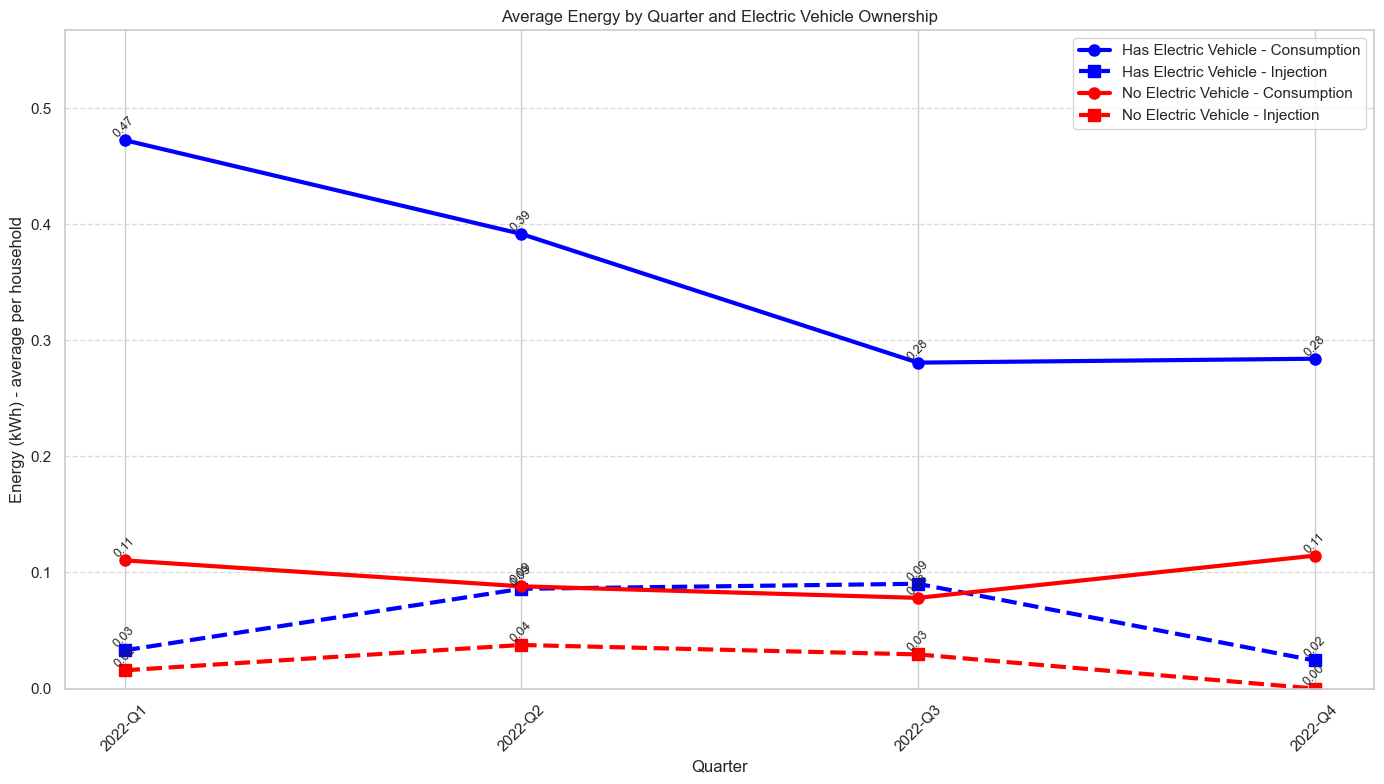

In Q1, Has Electric Vehicle mean 327.8% more electricity than No Electric Vehicle
In Q2, Has Electric Vehicle mean 344.7% more electricity than No Electric Vehicle
In Q3, Has Electric Vehicle mean 259.5% more electricity than No Electric Vehicle
In Q4, Has Electric Vehicle mean 148.2% more electricity than No Electric Vehicle


In [39]:
analyze_quarterly_by_indicator(df, 'Electric_Vehicle_Indicator', 'mean')


Average Quarterly Energy by Heat Pump Ownership:


,Year,Quarter,Heat_Pump_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Quarter_Label
0,2022,1,0,0.231170,0.021435,6,No Heat Pump,2022-Q1
1,2022,2,0,0.189317,0.053681,6,No Heat Pump,2022-Q2
2,2022,3,0,0.147538,0.050264,6,No Heat Pump,2022-Q3
3,2022,4,0,0.182367,0.009668,5,No Heat Pump,2022-Q4


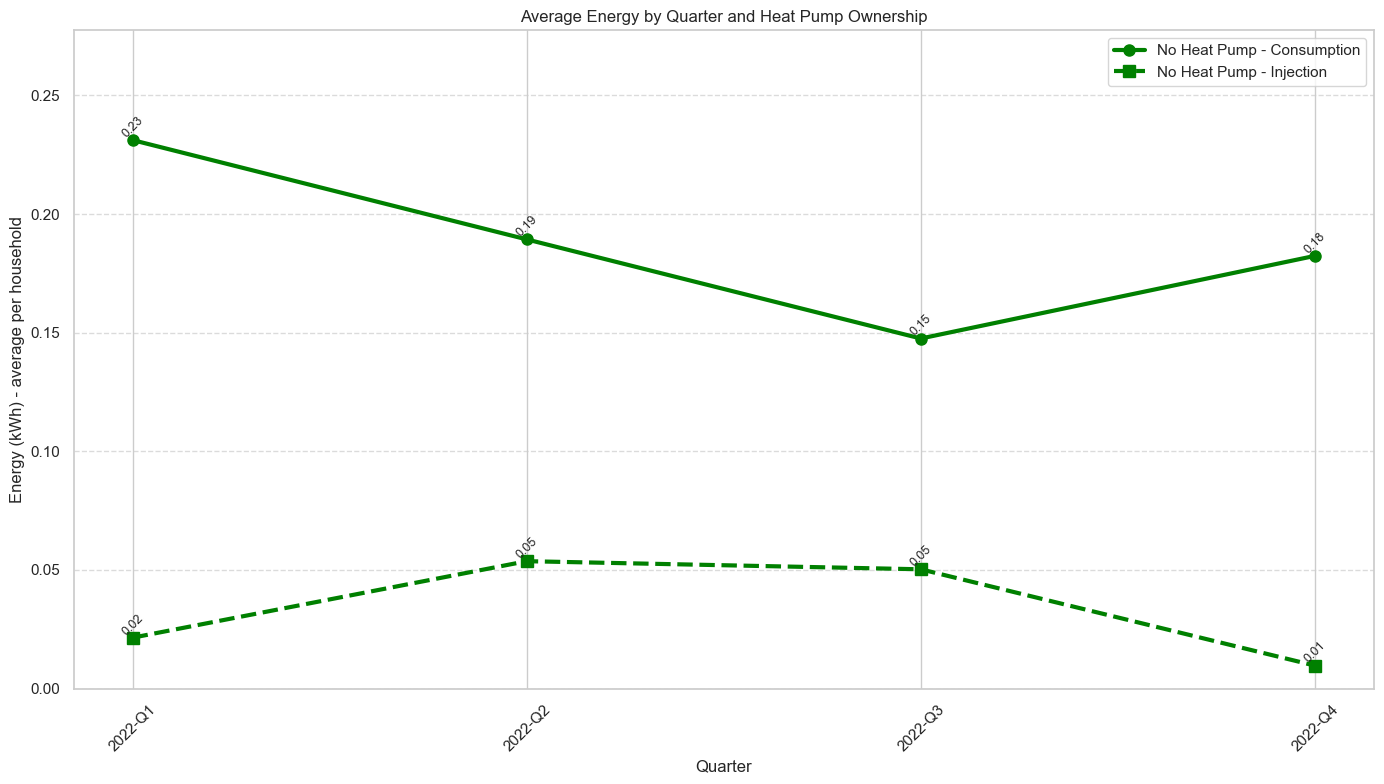

Only one heat pump status present in data, no comparison possible


In [40]:
analyze_quarterly_by_indicator(df, 'Heat_Pump_Indicator', 'mean')


Average Quarterly Energy by Solar Panel Ownership:


,Year,Quarter,PV_Installation_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Quarter_Label
1,2022,1,1,0.208453,0.064306,2,Has Solar Panel,2022-Q1
3,2022,2,1,0.100976,0.161042,2,Has Solar Panel,2022-Q2
5,2022,3,1,0.083164,0.159499,2,Has Solar Panel,2022-Q3
7,2022,4,1,0.220262,0.048342,1,Has Solar Panel,2022-Q4
0,2022,1,0,0.242529,0.000000,4,No Solar Panel,2022-Q1
2,2022,2,0,0.233488,0.000000,4,No Solar Panel,2022-Q2
4,2022,3,0,0.177160,0.000000,4,No Solar Panel,2022-Q3
6,2022,4,0,0.172894,0.000000,4,No Solar Panel,2022-Q4


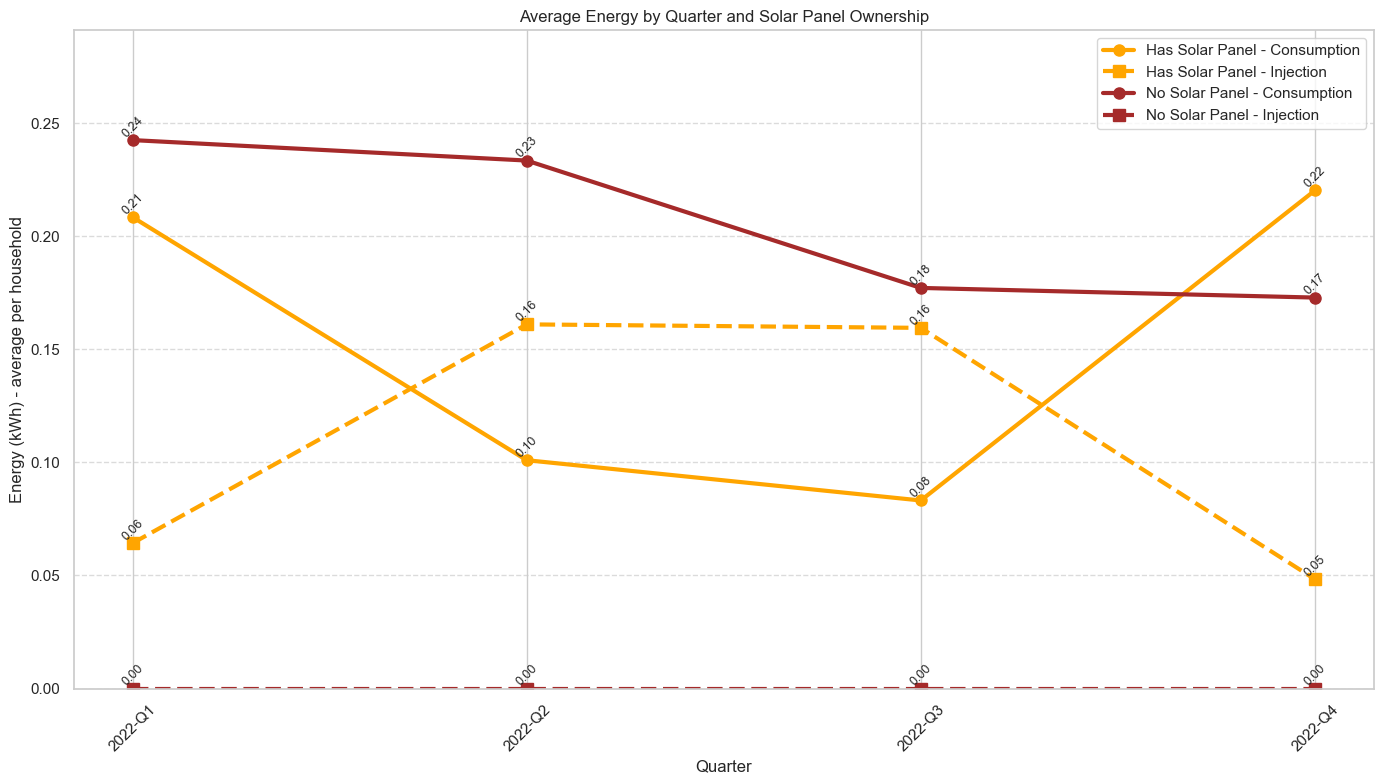

In Q1, Has Solar Panel mean -14.1% less electricity than No Solar Panel
In Q2, Has Solar Panel mean -56.8% less electricity than No Solar Panel
In Q3, Has Solar Panel mean -53.1% less electricity than No Solar Panel
In Q4, Has Solar Panel mean 27.4% more electricity than No Solar Panel


In [41]:
analyze_quarterly_by_indicator(df, 'PV_Installation_Indicator', 'mean')

# 6. Time Serie (Hourly) vs 5 combinations

In [42]:
def analyze_hourly_by_indicator(df, indicator_column, aggregation_method='sum'):
    """
    Analyze hourly consumption patterns by a binary indicator (0/1).
    
    Parameters:
    - df: DataFrame containing the data
    - indicator_column: Name of the column with binary indicator (e.g., 'Electric_Vehicle_Indicator')
    - aggregation_method: Method to aggregate energy values ('sum' or 'mean')
    """
    import itertools
    import matplotlib.pyplot as plt
    import numpy as np
    
    if indicator_column not in df.columns:
        print(f"{indicator_column} not found in the dataset")
        return
    
    # Map indicator names to feature names and colors
    indicator_mapping = {
        'Electric_Vehicle_Indicator': {'name': 'Electric Vehicle', 
                                      'colors': ['blue', 'red']},
        'Heat_Pump_Indicator': {'name': 'Heat Pump', 
                               'colors': ['green', 'purple']},
        'PV_Installation_Indicator': {'name': 'Solar Panel', 
                                     'colors': ['orange', 'brown']}
    }
    
    # Get feature info or create default
    feature_info = indicator_mapping.get(indicator_column, {
        'name': indicator_column.replace('_Indicator', '').replace('_', ' '),
        'colors': ['blue', 'red']
    })
    
    feature_name = feature_info['name']
    colors = feature_info['colors']
        
    # Validate aggregation method
    if aggregation_method not in ['sum', 'mean']:
        print(f"Invalid aggregation method: {aggregation_method}. Using 'sum' instead.")
        aggregation_method = 'sum'
    
    # Group by Hour and the indicator
    combined_agg = df.groupby(['Hour', indicator_column]).agg({
        'Volume_Consumption_kWh': aggregation_method,
        'Volume_Injection_kWh': aggregation_method,
        'EAN_ID': 'nunique'  # Count unique households
    }).reset_index()
    
    # Create a mapping dictionary based on available values
    index_mapping = {}
    if 0 in combined_agg[indicator_column].unique():
        index_mapping[0] = f'No {feature_name}'
    if 1 in combined_agg[indicator_column].unique():
        index_mapping[1] = f'Has {feature_name}'
    
    # Apply mapping to create a new readable column
    combined_agg['Status'] = combined_agg[indicator_column].map(
        lambda x: index_mapping.get(x, f'Value {x}')
    )
    
    # Format hour for display
    combined_agg['Hour_Display'] = combined_agg['Hour'].apply(lambda x: f'{x:02d}:00')
    
    # Sort by Hour and Status for consistent ordering
    combined_agg = combined_agg.sort_values(['Status', 'Hour'])
    
    agg_display_name = "Total" if aggregation_method == 'sum' else "Average"
    print(f"{agg_display_name} Hourly Energy by {feature_name} Ownership:")
    display(combined_agg)
    
    # Create a single plot
    plt.figure(figsize=(14, 8))
    
    # Get unique statuses
    status_values = combined_agg['Status'].unique()
    
    # Track max height for y-axis scaling
    max_value = 0
    
    # Plot all lines on the same graph
    for i, status in enumerate(sorted(status_values)):
        status_data = combined_agg[combined_agg['Status'] == status]
        color = colors[i % len(colors)]
        
        # Plot consumption (solid line)
        plt.plot(status_data['Hour'], status_data['Volume_Consumption_kWh'], 
                marker='o', linewidth=3, markersize=8, 
                color=color, linestyle='-',
                label=f'{status} - Consumption')
        
        # Plot injection (dashed line)
        plt.plot(status_data['Hour'], status_data['Volume_Injection_kWh'], 
                marker='s', linewidth=3, markersize=8, 
                color=color, linestyle='--',
                label=f'{status} - Injection')
        
        # Update max value
        max_value = max(max_value, 
                      status_data['Volume_Consumption_kWh'].max(), 
                      status_data['Volume_Injection_kWh'].max())
        
    # Set title and labels
    plt.title(f'{agg_display_name} Energy by Hour and {feature_name} Ownership')
    
    energy_label = f'Energy (kWh) - {agg_display_name.lower()} per household' if aggregation_method == 'mean' else 'Energy (kWh)'
    plt.ylabel(energy_label)
    plt.xlabel('Hour of Day')
    
    # Set x ticks for every hour
    plt.xticks(range(0, 24), 
               [f'{h:02d}:00' for h in range(0, 24)], 
               rotation=45)
    
    # Set proper y-limit
    y_pad = 1.2 if aggregation_method == 'mean' else 1.1  # 20% padding for mean, 10% for sum
    plt.ylim(0, max_value * y_pad)
    
    # Add grid and legend
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend()
    
    plt.tight_layout()
    
    # Create snake_case filename
    filename = f"hourly_{aggregation_method}_by_{feature_name.lower().replace(' ', '_')}"
    plt.savefig(f'analysis_results/{filename}.png', dpi=300)
    plt.show()
    
    # Calculate peak hour differences if possible
    if len(status_values) > 1:
        # Find peak consumption hours for each status
        for status in status_values:
            status_data = combined_agg[combined_agg['Status'] == status]
            peak_hour = status_data.loc[status_data['Volume_Consumption_kWh'].idxmax()]
            print(f"Peak consumption for {status} is at {peak_hour['Hour_Display']} ({peak_hour['Volume_Consumption_kWh']:.2f} kWh)")
        
        # Calculate percentage differences at each hour
        print("\nHourly consumption differences:")
        for hour in range(0, 24):
            status_data = {}
            for status in status_values:
                data = combined_agg[(combined_agg['Hour'] == hour) & 
                                  (combined_agg['Status'] == status)]
                if not data.empty:
                    status_data[status] = data
            
            # If we have data for multiple statuses, calculate difference
            if len(status_data) > 1:
                status_pairs = list(itertools.combinations(status_values, 2))
                for status1, status2 in status_pairs:
                    if status1 in status_data and status2 in status_data:
                        s1_data = status_data[status1]
                        s2_data = status_data[status2]
                        consumption_diff = (s1_data['Volume_Consumption_kWh'].values[0] / 
                                          s2_data['Volume_Consumption_kWh'].values[0] - 1) * 100
                        
                        # Only show significant differences (>10%)
                        if abs(consumption_diff) > 10:
                            hour_display = f'{hour:02d}:00'
                            print(f"At {hour_display}, {status1} {aggregation_method} {consumption_diff:.1f}% " + 
                                  f"{'more' if consumption_diff > 0 else 'less'} electricity than {status2}")
    else:
        print(f"Only one {feature_name.lower()} status present in data, no comparison possible")

Average Hourly Energy by Electric Vehicle Ownership:


,Hour,Electric_Vehicle_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Hour_Display
1,0,1,0.346052,0.000000e+00,2,Has Electric Vehicle,00:00
3,1,1,0.368197,0.000000e+00,2,Has Electric Vehicle,01:00
5,2,1,0.448584,0.000000e+00,2,Has Electric Vehicle,02:00
7,3,1,0.448486,0.000000e+00,2,Has Electric Vehicle,03:00
9,4,1,0.417284,1.356164e-04,2,Has Electric Vehicle,04:00
11,5,1,0.383326,4.208491e-03,2,Has Electric Vehicle,05:00
13,6,1,0.364352,1.970153e-02,2,Has Electric Vehicle,06:00
15,7,1,0.322107,4.625628e-02,2,Has Electric Vehicle,07:00
17,8,1,0.273738,9.736470e-02,2,Has Electric Vehicle,08:00
19,9,1,0.309400,1.505038e-01,2,Has Electric Vehicle,09:00


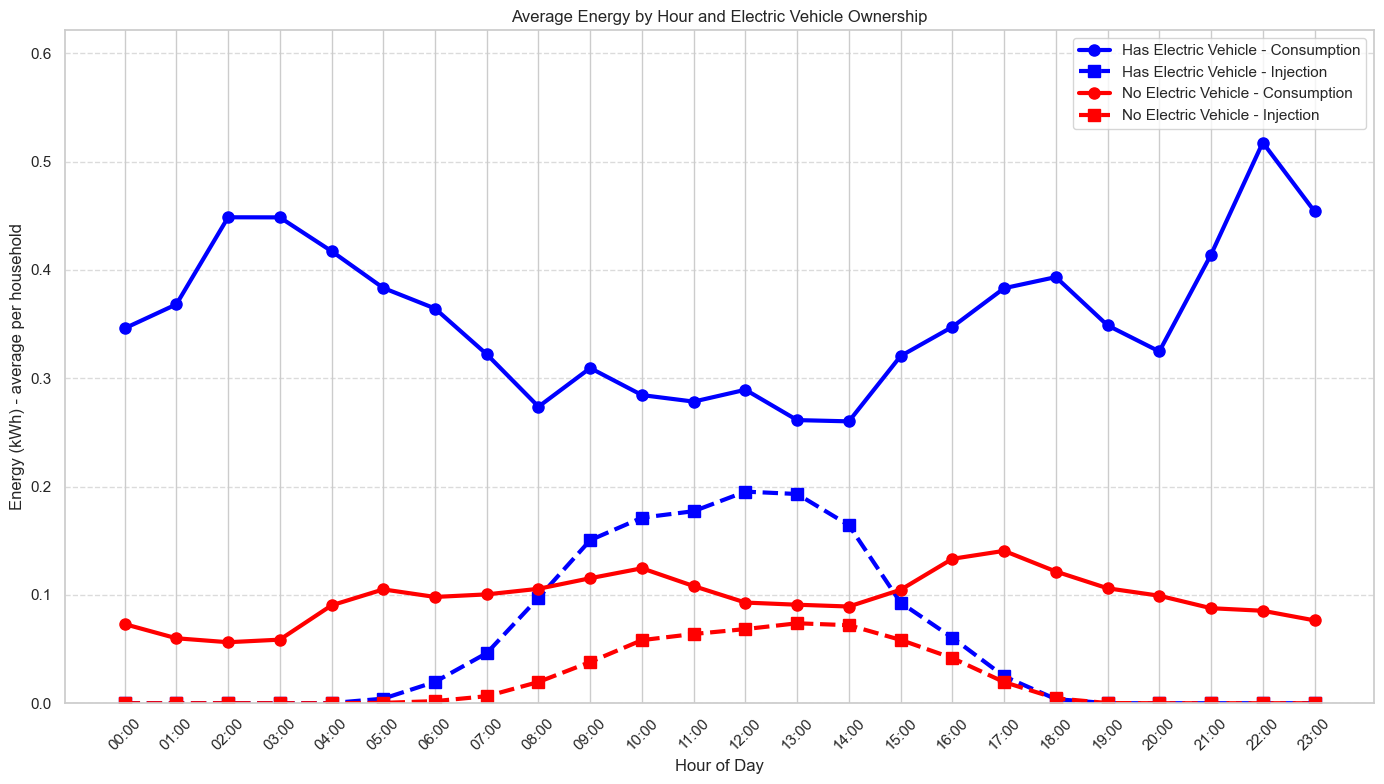

Peak consumption for Has Electric Vehicle is at 22:00 (0.52 kWh)
Peak consumption for No Electric Vehicle is at 17:00 (0.14 kWh)

Hourly consumption differences:
At 00:00, Has Electric Vehicle mean 373.9% more electricity than No Electric Vehicle
At 01:00, Has Electric Vehicle mean 514.1% more electricity than No Electric Vehicle
At 02:00, Has Electric Vehicle mean 696.7% more electricity than No Electric Vehicle
At 03:00, Has Electric Vehicle mean 664.2% more electricity than No Electric Vehicle
At 04:00, Has Electric Vehicle mean 361.9% more electricity than No Electric Vehicle
At 05:00, Has Electric Vehicle mean 264.8% more electricity than No Electric Vehicle
At 06:00, Has Electric Vehicle mean 271.4% more electricity than No Electric Vehicle
At 07:00, Has Electric Vehicle mean 220.6% more electricity than No Electric Vehicle
At 08:00, Has Electric Vehicle mean 159.2% more electricity than No Electric Vehicle
At 09:00, Has Electric Vehicle mean 168.1% more electricity than No Elect

In [44]:
analyze_hourly_by_indicator(df, 'Electric_Vehicle_Indicator', 'mean')


Average Hourly Energy by Heat Pump Ownership:


,Hour,Heat_Pump_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Hour_Display
0,0,0,0.168664,0.000000,6,No Heat Pump,00:00
1,1,0,0.167929,0.000000,6,No Heat Pump,01:00
2,2,0,0.193715,0.000000,6,No Heat Pump,02:00
3,3,0,0.195227,0.000000,6,No Heat Pump,03:00
4,4,0,0.204870,0.000050,6,No Heat Pump,04:00
5,5,0,0.202542,0.001687,6,No Heat Pump,05:00
6,6,0,0.191360,0.008152,6,No Heat Pump,06:00
7,7,0,0.178105,0.020415,6,No Heat Pump,07:00
8,8,0,0.164540,0.046857,6,No Heat Pump,08:00
9,9,0,0.183381,0.077455,6,No Heat Pump,09:00


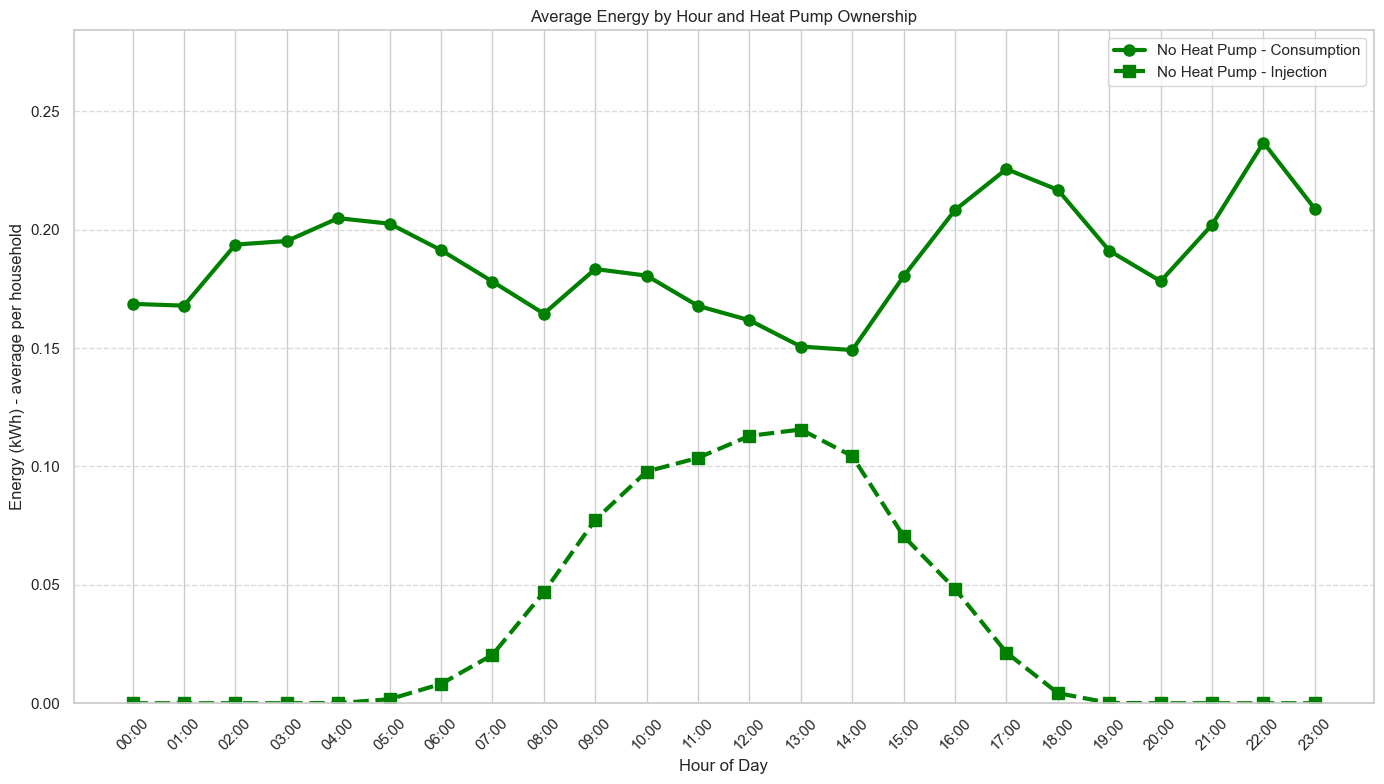

Only one heat pump status present in data, no comparison possible


In [45]:
analyze_hourly_by_indicator(df, 'Heat_Pump_Indicator', 'mean')


Average Hourly Energy by Solar Panel Ownership:


,Hour,PV_Installation_Indicator,Volume_Consumption_kWh,Volume_Injection_kWh,EAN_ID,Status,Hour_Display
1,0,1,0.132339,0.000000,2,Has Solar Panel,00:00
3,1,1,0.142582,0.000000,2,Has Solar Panel,01:00
5,2,1,0.149257,0.000000,2,Has Solar Panel,02:00
7,3,1,0.167036,0.000000,2,Has Solar Panel,03:00
9,4,1,0.230021,0.000167,2,Has Solar Panel,04:00
11,5,1,0.259532,0.005635,2,Has Solar Panel,05:00
13,6,1,0.221155,0.027225,2,Has Solar Panel,06:00
15,7,1,0.185557,0.068181,2,Has Solar Panel,07:00
17,8,1,0.138812,0.156668,2,Has Solar Panel,08:00
19,9,1,0.114598,0.258970,2,Has Solar Panel,09:00


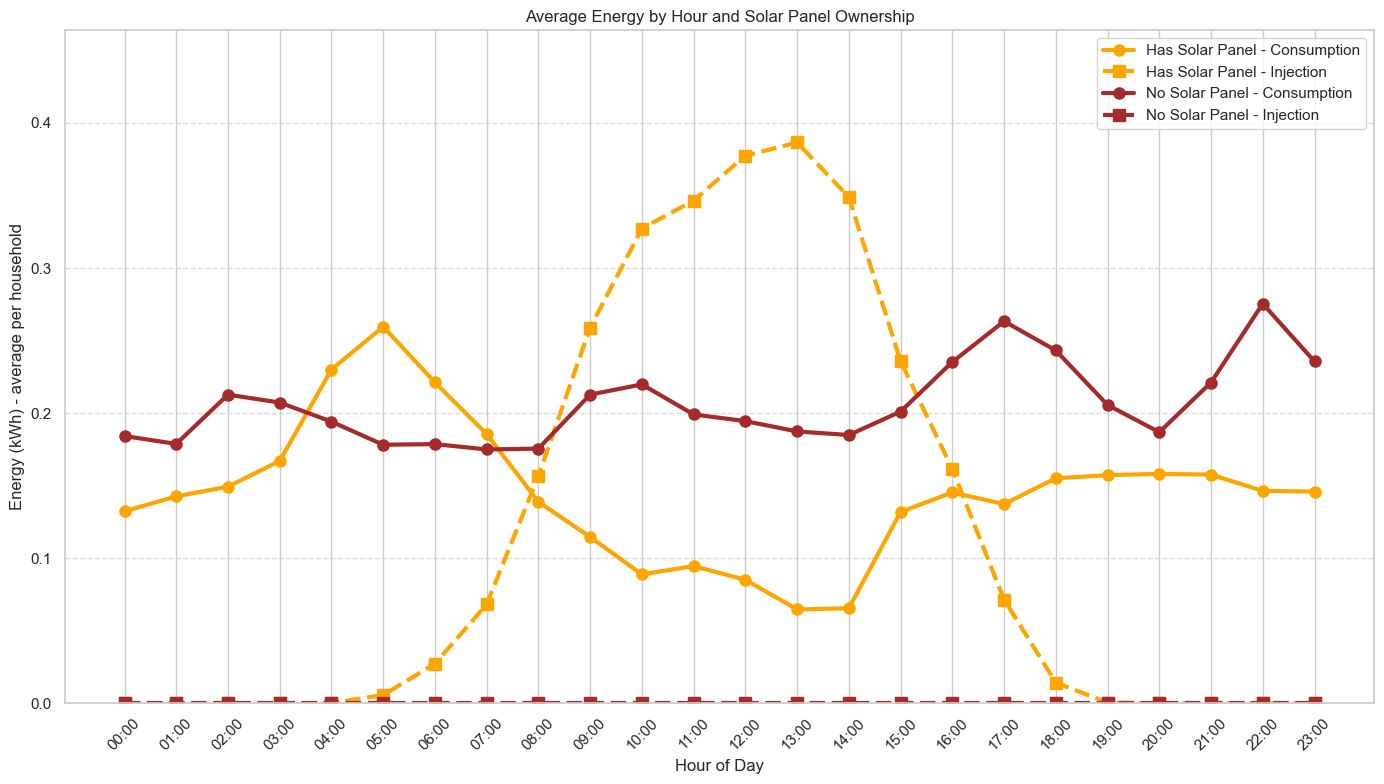

Peak consumption for Has Solar Panel is at 05:00 (0.26 kWh)
Peak consumption for No Solar Panel is at 22:00 (0.28 kWh)

Hourly consumption differences:
At 00:00, Has Solar Panel mean -28.2% less electricity than No Solar Panel
At 01:00, Has Solar Panel mean -20.2% less electricity than No Solar Panel
At 02:00, Has Solar Panel mean -29.8% less electricity than No Solar Panel
At 03:00, Has Solar Panel mean -19.4% less electricity than No Solar Panel
At 04:00, Has Solar Panel mean 18.5% more electricity than No Solar Panel
At 05:00, Has Solar Panel mean 45.7% more electricity than No Solar Panel
At 06:00, Has Solar Panel mean 23.8% more electricity than No Solar Panel
At 08:00, Has Solar Panel mean -20.9% less electricity than No Solar Panel
At 09:00, Has Solar Panel mean -46.1% less electricity than No Solar Panel
At 10:00, Has Solar Panel mean -59.6% less electricity than No Solar Panel
At 11:00, Has Solar Panel mean -52.5% less electricity than No Solar Panel
At 12:00, Has Solar Panel 

In [46]:
analyze_hourly_by_indicator(df, 'PV_Installation_Indicator', 'mean')